**I certify that the code and data in this assignment were generated independently, using only the toolsand resources defined in the course and that I did not receive any external help, coaching or contributions
during the production of this work.**

In [84]:
!pip install gym
!pip install -U -q PyDrive

In [85]:
import numpy as np
import random
import matplotlib.pyplot as plt
import gym
from gym import spaces
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from calendar import c

**Uploading Images from the Drive**

In [86]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [87]:
Animal = drive.CreateFile({'id':'1qn3Y15ZrEwG7T4L_UKyPqBworTI5DNVe'})
Animal.GetContentFile('Animal.jpg')
LostMan = drive.CreateFile({'id':'1C0Hn5XrykE52LkBQAujWCTsmCnOWAp7s'})
LostMan.GetContentFile('LostMan.jpg')
Chicken = drive.CreateFile({'id':'1YBJCgzJndGSpHVyqNtOtLzPiuxR7TRIx'})
Chicken.GetContentFile('Chicken.jpg')
Ghost = drive.CreateFile({'id':'1IY_XgH9OmcWDVwZn80pYWM-Jq4nmr8OD'})
Ghost.GetContentFile('Ghost.jpg')
Apple = drive.CreateFile({'id':'1Aq1NbLDLUT6nZ3H5KUBQsCCIwHPb1YPV'})
Apple.GetContentFile('Apple.jpg')
Pit = drive.CreateFile({'id':'147DH_q9x9ALr6NXyOaA9332fq7GHEt5M'})
Pit.GetContentFile('Pit.jpg')
Exit = drive.CreateFile({'id':'1p12iKCJbPLGNzufZzbX6n-dS8rz98j9y'})
Exit.GetContentFile('Exit.jpg')

**Deterministic and Stochastic environment**

In [96]:
class GridEnvironment():
  def __init__(self):
    self.observation_space = spaces.Discrete(36)
    self.action_space = spaces.Discrete(5)
    self.max_timesteps = 1000
    # self.environment_height = 6
    # self.environment_width = 6

  def reset(self):
    self.timestep = 0
    self.reward = 0
    self.agent_pos = [0, 0] #initial position
    self.goal_pos= [5,5] #goal position
    self.apple_pos=[1,2],[1,5] #apple position
    self.pit_pos=[5,4],[0,4] #pit position
    self.ghost_pos=[3,1],[2,5] #ghost position
    self.chicken_pos=[3,0],[3,3] #chicken position
    self.environment_height = 6
    self.environment_width = 6
    self.state = np.zeros((6,6))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.rewards={}
    observation = self.state.flatten()
    return observation
  
  def step(self, action,is_stochastic_env=False): # if is_stochastic-env is True then it is stochastic environment else it is deterministic environment
    self.state = np.random.choice(self.observation_space.n)
    self.reward-=5
    discount_factor = 0.95
    if action == 0: # right
     self.agent_pos[0] += 1
    if action == 1: # left
     self.agent_pos[0] -= 1
    if action == 2: # up
     self.agent_pos[1] += 1 
    if action == 3: # down
     self.agent_pos[1] -= 1
    if action ==4: # 2_step
      self.agent_pos[0] +=2
      self.reward-=5

    if is_stochastic_env:
      if random.random()<= 0.2:
        action==0
        self.agent_pos[0] += 1
      elif 0.2< random.random()<= 0.4:
        action==1
        self.agent_pos[0] -= 1
      elif 0.4< random.random()<= 0.6:
        action==2
        self.agent_pos[1] += 1
      elif 0.6< random.random()<= 0.8:
        action==3
        self.agent_pos[1] -= 1
      elif random.random()> 0.8 :
        action==4
        self.agent_pos[0] +=2
        self.reward-=5

    action = np.clip(action, 0, 4)
    self.agent_pos = np.clip(self.agent_pos, 0, 5)
    self.state = np.zeros((6,6))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()
    observation=observation.astype(int)
    done = False
    
    if (self.agent_pos == self.goal_pos).all():
     self.reward += 100
     done = True
    elif any(np.array_equal(self.agent_pos,self.apple_pos[i]) for i in range(len(self.apple_pos))):
      if tuple(self.agent_pos) not in self.rewards.keys():
        self.reward += 10
        self.rewards[tuple(self.agent_pos)] = 1
    elif any(np.array_equal(self.agent_pos,self.ghost_pos[i]) for i in range(len(self.ghost_pos))):
      if tuple(self.agent_pos) not in self.rewards.keys():
        self.reward -= 50
        self.rewards[tuple(self.agent_pos)] = 1
      self.agent_pos = [0,0]
    elif any(np.array_equal(self.agent_pos,self.pit_pos[i]) for i in range(len(self.pit_pos))):
      if tuple(self.agent_pos) not in self.rewards.keys():
        self.reward -= 10
        self.rewards[tuple(self.agent_pos)] = 1
      self.agent_pos = [2,3]
    elif any(np.array_equal(self.agent_pos,self.chicken_pos[i]) for i in range(len(self.chicken_pos))):
      if tuple(self.agent_pos) not in self.rewards.keys():
        self.reward += 20
        self.rewards[tuple(self.agent_pos)] = 1

    self.timestep += 1
    if not done:
      done = True if (self.timestep >= self.max_timesteps) else False
    info = {}
    return observation, self.reward, done, info
# referenced from TA Demo video
  from matplotlib.text import Annotation
  def render(self,mode="human",plot = False):
   fig, ax = plt.subplots(figsize=(10,10))
   ax.set_xlim(0,6)
   ax.set_ylim(0,6)

   def plot_image(plot_pos):
    plot_agent,plot_apple,plot_chicken,plot_pit,plot_ghost,plot_animal,plot_goal = \
    False,False,False,False,False,False,False
    if np.array_equal(self.agent_pos, plot_pos):
     plot_agent=True
    if any(np.array_equal(self.apple_pos[i], plot_pos) for i in range(len(self.apple_pos))):
     plot_apple=True
    if any(np.array_equal(self.chicken_pos[i], plot_pos) for i in range(len(self.chicken_pos))):
     plot_chicken=True
    if any(np.array_equal(self.pit_pos[i], plot_pos) for i in range(len(self.pit_pos))):
     plot_pit=True
    if any(np.array_equal(self.ghost_pos[i], plot_pos) for i in range(len(self.ghost_pos))):
     plot_ghost=True
    if np.array_equal(self.goal_pos, plot_pos):
     plot_goal=True
   
    if plot_agent and \
        all(not item for item in [plot_apple,plot_chicken,plot_pit,plot_ghost,plot_goal]):
        agent= AnnotationBbox(OffsetImage(plt.imread('LostMan.jpg'), zoom=0.30),
         np.add(plot_pos, [0.5,0.5]), frameon=False)
        ax.add_artist(agent)
   
    #Image for apple
    elif plot_apple and all(not item for item in
          [plot_agent,plot_chicken,plot_pit,plot_ghost,plot_goal]):
     apple= AnnotationBbox(OffsetImage(plt.imread("Apple.jpg"), zoom=0.32),
                np.add(plot_pos, [0.5, 0.5]), frameon= False)
     ax.add_artist(apple)

    #Image for chicken
    elif plot_chicken and all(not item for item in
          [plot_agent,plot_apple, plot_pit, plot_ghost,plot_goal]):
     chicken= AnnotationBbox(OffsetImage(plt.imread('Chicken.jpg'), zoom=0.18),
               np.add(plot_pos, [0.5, 0.5]), frameon= False)
     ax.add_artist(chicken)

    #Image for pit
    elif plot_pit and all(not item for item in
          [plot_agent, plot_apple,plot_chicken,plot_ghost,plot_goal]):
     pit = AnnotationBbox(OffsetImage(plt.imread('Pit.jpg'), zoom=0.25),
          np.add(plot_pos, [0.5, 0.5]), frameon= False)
     ax.add_artist(pit)

     #Image for ghost
    elif plot_ghost and all(not item for item in
          [plot_agent, plot_apple,plot_chicken,plot_pit,plot_goal]):
     ghost = AnnotationBbox(OffsetImage(plt.imread('Ghost.jpg'), zoom=0.30),
          np.add(plot_pos, [0.5, 0.5]), frameon= False)
     ax.add_artist(ghost)

     #image for goal
    elif plot_goal and all(not item for item in
         [plot_agent, plot_apple,plot_chicken,plot_pit,plot_ghost]):
     goal = AnnotationBbox(OffsetImage(plt.imread('Exit.jpg'), zoom=0.25),
         np.add(plot_pos, [0.5, 0.5]), frameon= False)
     ax.add_artist(goal)

   coordinates_state_mapping_2 = {}
   for j in range(self.environment_height * self.environment_width):
    coordinates_state_mapping_2[j] = np.asarray(
      [j % self.environment_width, int(np.floor(j / self.environment_width))])

   for position in coordinates_state_mapping_2:
    plot_image(coordinates_state_mapping_2[position])
   plt.xticks([0, 1, 2, 3, 4, 5])
   plt.yticks([0, 1, 2, 3, 4, 5])
   plt.grid()
   plot_image(self.agent_pos)
   plt.show()

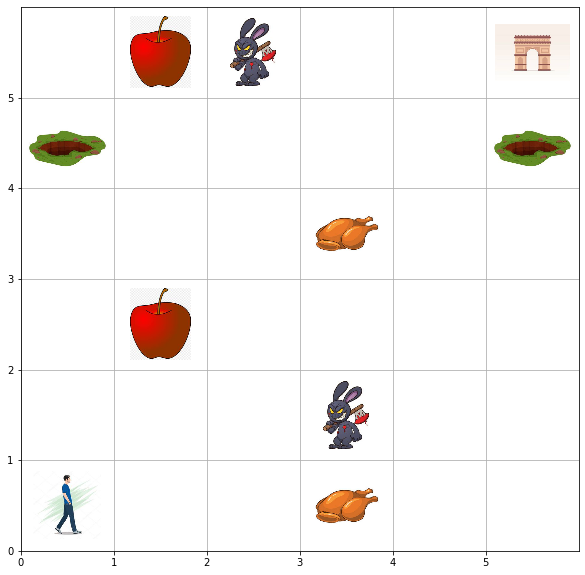

In [97]:
env = GridEnvironment()
obs = env.reset()
env.render()

In [98]:
env=GridEnvironment()

dict_res = {}
k = 0
for i in range(6):
  for j in range(6):
    dict_res[(j, i)] = k
    k+=1

class QL_Agent:
    def __init__(self,env,discount_factor,learning_rate,epsilon): 
        self.g =discount_factor
        self.lr= learning_rate
        self.epsilon = epsilon
        self.terminals=[[3,1],[2,5],[5,5]]
        action_size=env.action_space.n     
        state_size=env.observation_space.n

        self.Qtable =np.zeros((state_size,action_size))
  

    def action(self,s):
        tradeoff=np.random.random(1)
        if tradeoff >self.epsilon:
            action=np.argmax(self.Qtable[s,:])
        else:
            action=env.action_space.sample()
        return action


    def update_QL(self,s,a,r,s_):
        self.Qtable[s,a] = self.Qtable[s,a] + \
        self.lr*(r+self.g*np.max(self.Qtable[s_,:])-self.Qtable[s,a])

**Qlearning**

final_Qtable
---------------
[[ -78.38064574  -89.71041749  -55.69063978  -86.03870039  -81.34909567]
 [ -69.88893191  -72.63094387  -59.99535626  -75.05859764  -68.97923629]
 [ -77.34889988  -70.65240195  -70.32554079  -73.08130729  -70.9263807 ]
 [ -77.3267956   -74.75428222  -79.00649705  -75.40564176  -77.98988238]
 [ -73.35798691  -73.90632894  -77.74404692  -72.55049527  -80.79343437]
 [ -77.33768111  -78.64449161  -78.45308092  -81.01826424  -84.13314928]
 [ -67.82916923  -67.43668931  -35.97772907  -73.01600933  -73.96047959]
 [ -73.5592795   -62.75054707  -33.39809481  -62.41795742 -107.30642678]
 [ -68.09930119  -64.38824106  -66.21141503  -66.13842996  -74.12431415]
 [   0.            0.            0.            0.            0.        ]
 [ -67.53817055  -73.77622422  -68.20082974  -66.90673707  -64.23705151]
 [ -66.05227309  -66.41034254  -64.81809659  -67.89391076  -62.65702265]
 [ -14.17772589  -49.79032557  -52.17727183  -57.60202348  -52.55831124]
 [ -46.98588302  -47.7

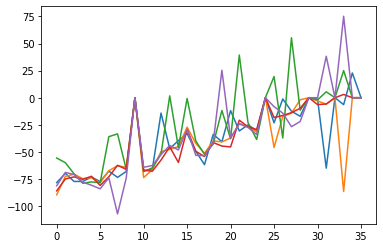

In [99]:
max_epsilon =1
min_epsilon =0.01
decay_rate = 0.0005
agentQL=QL_Agent(env,discount_factor=0.95,learning_rate=0.1,epsilon=max_epsilon)

total_episode=500
rewards= np.zeros((total_episode))
epsilons= np.zeros((total_episode))
eps_update = 0
for i in range(total_episode):
    total_rewards=0
    s=env.reset()
    s=dict_res[tuple(env.agent_pos)]
    for j in range(10):
        a =agentQL.action(s)
        a = np.clip(a, 0, 4)
        s_,r,done,_=env.step(a)
        s_=dict_res[tuple(env.agent_pos)]
        agentQL.update_QL(s,a,r,s_)
        s=s_
        total_rewards += r
        if done:
            break
    eps_update+=1
    if eps_update>1:
      agentQL.epsilon=min_epsilon+(max_epsilon-min_epsilon)-np.exp(-decay_rate*i)
      eps_update=0
    epsilons[i] = agentQL.epsilon
    rewards[i]=total_rewards
print("final_Qtable")
print("---------------")
print(agentQL.Qtable)
plt.plot(agentQL.Qtable)
plt.show()


**Evaluate Q learning agent  after training**

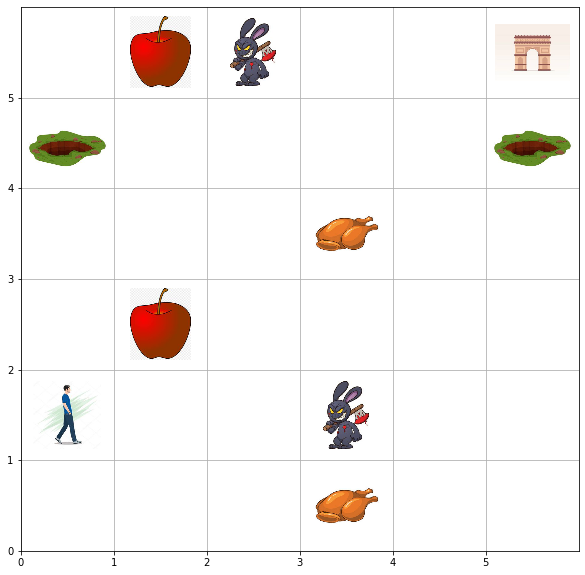

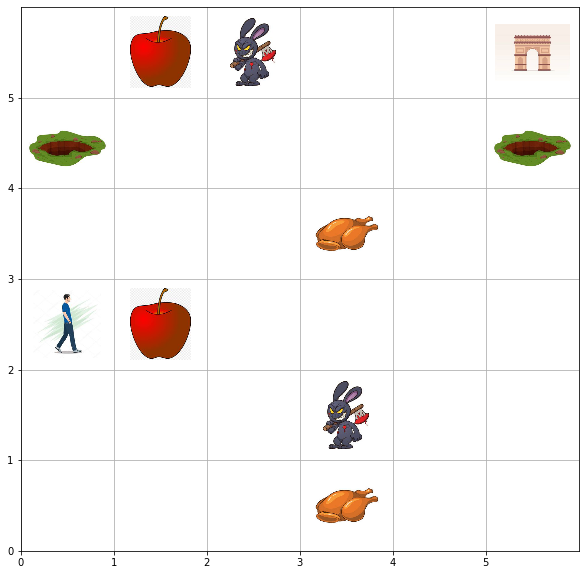

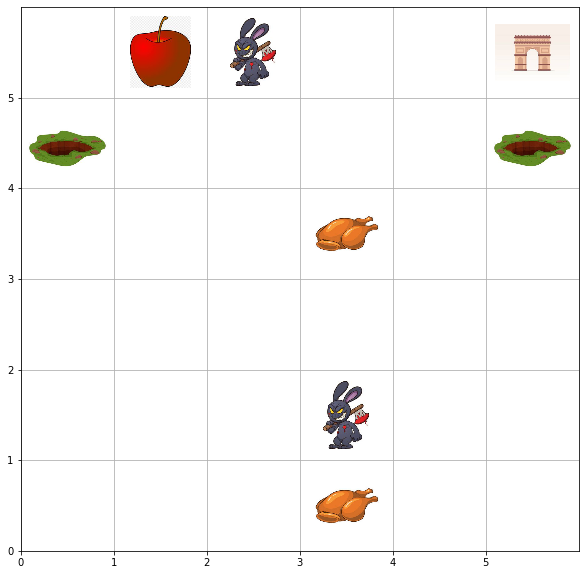

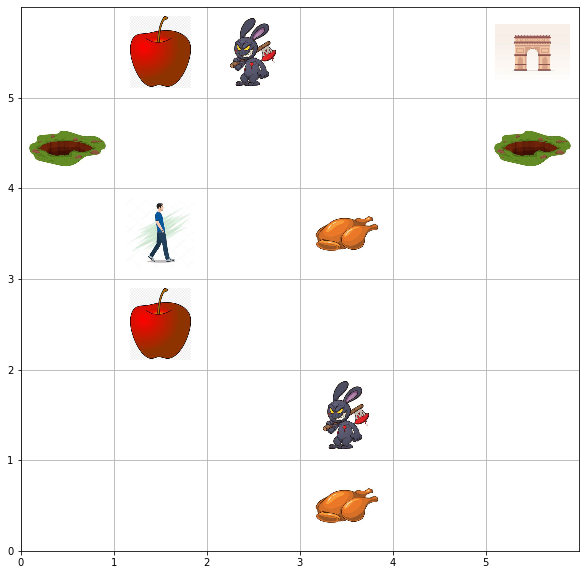

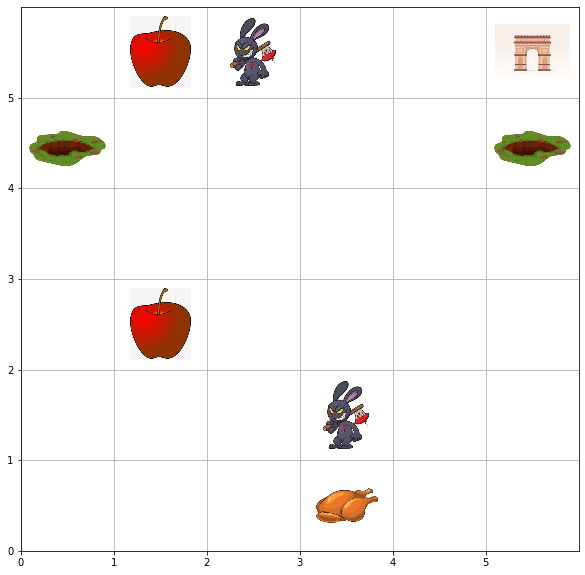

Evaluation Episode:0 -->Reward:-30.0
Mean Reward:-3.0


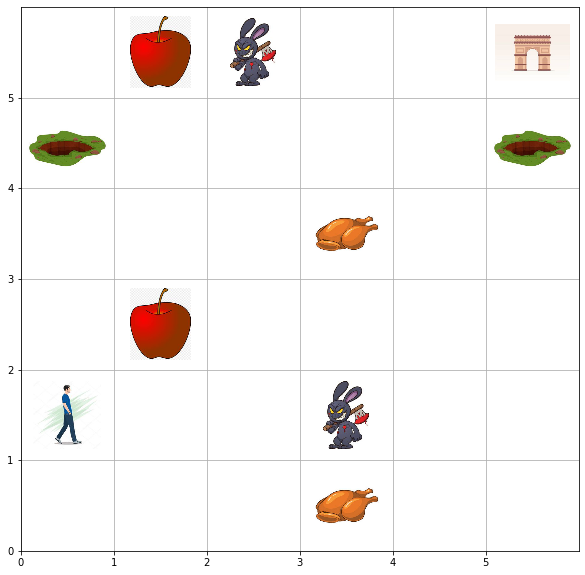

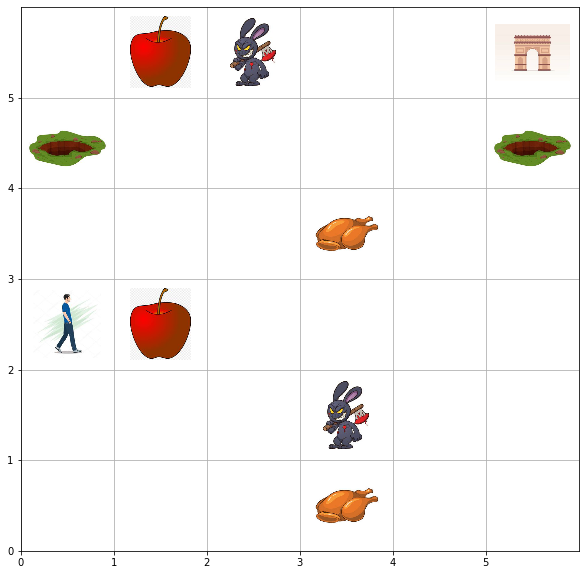

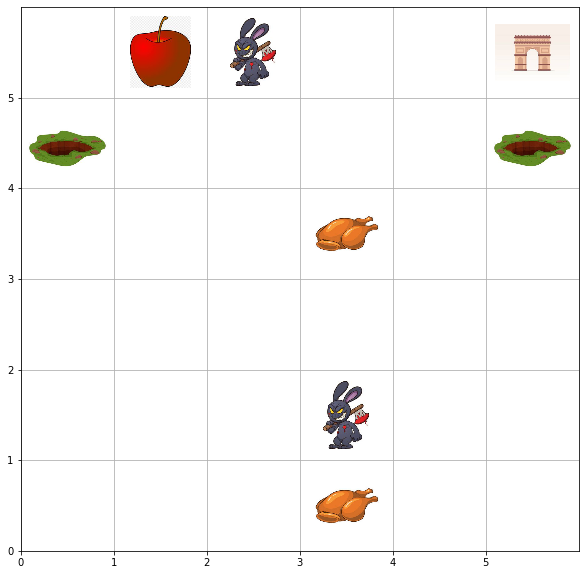

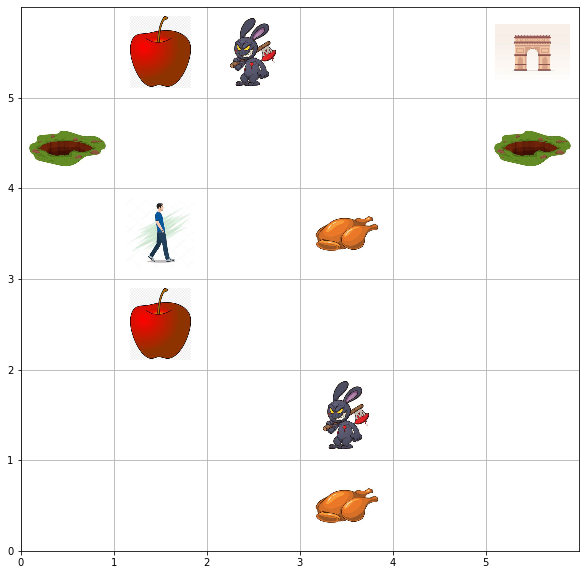

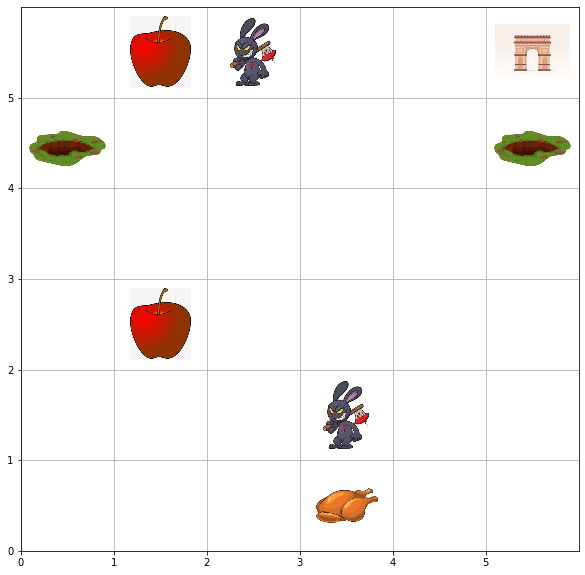

Evaluation Episode:1 -->Reward:-30.0
Mean Reward:-6.0


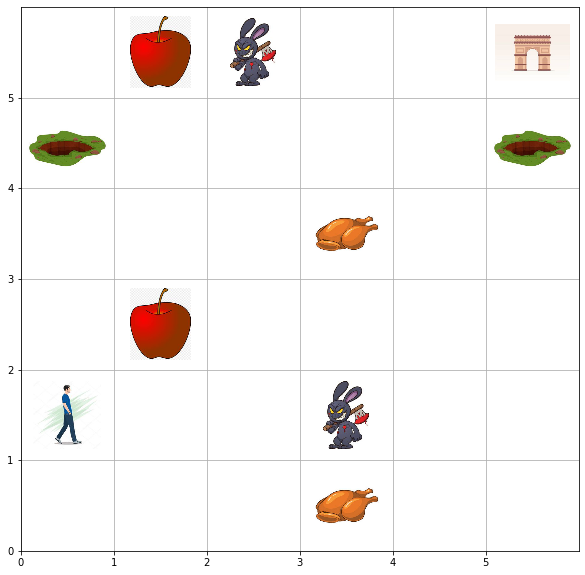

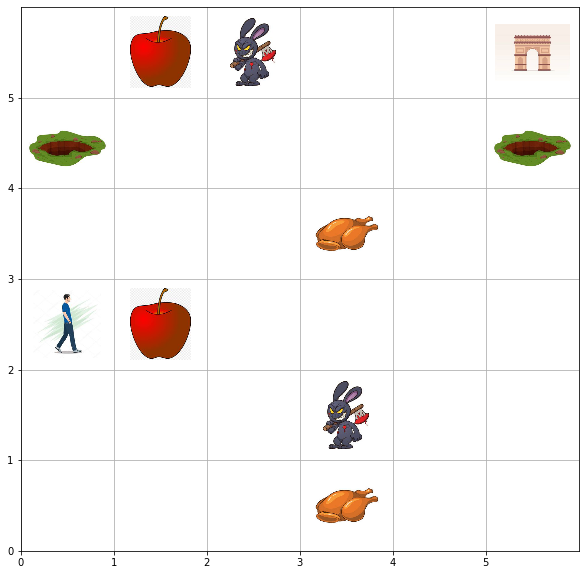

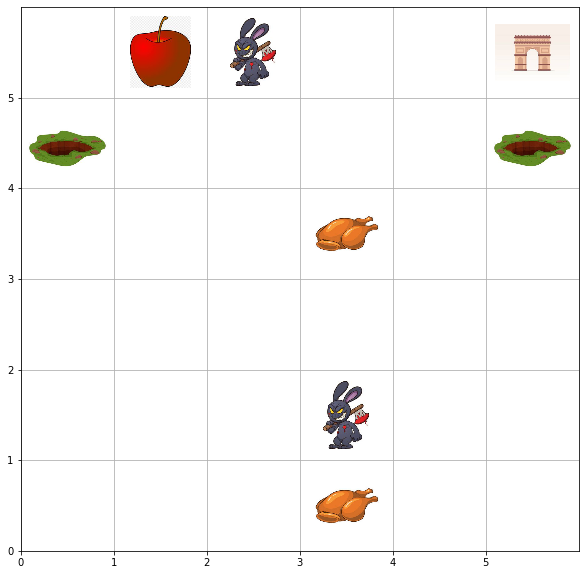

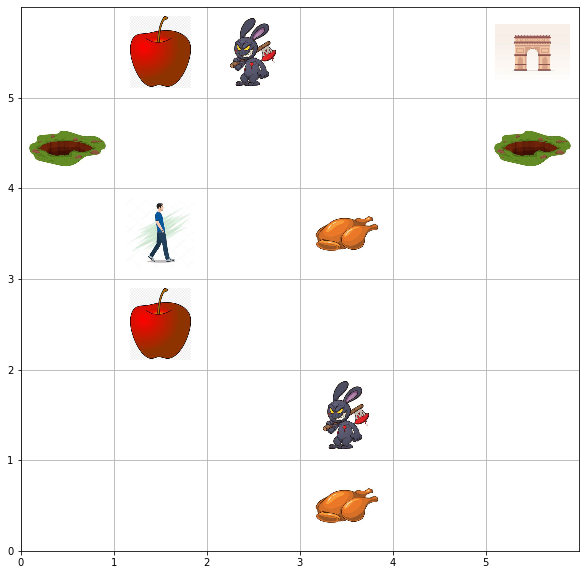

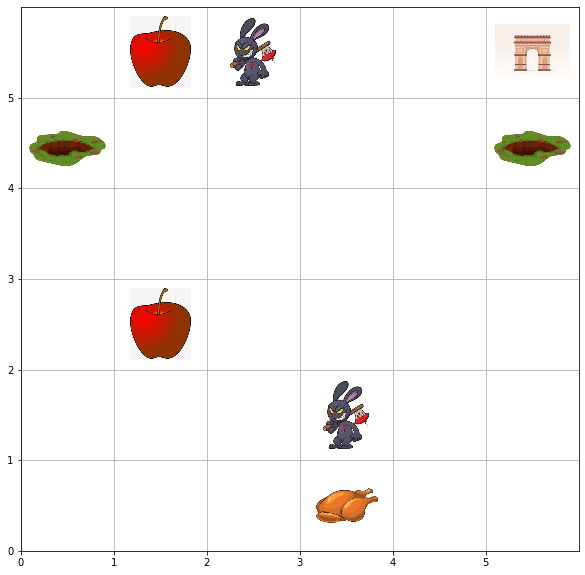

Evaluation Episode:2 -->Reward:-30.0
Mean Reward:-9.0


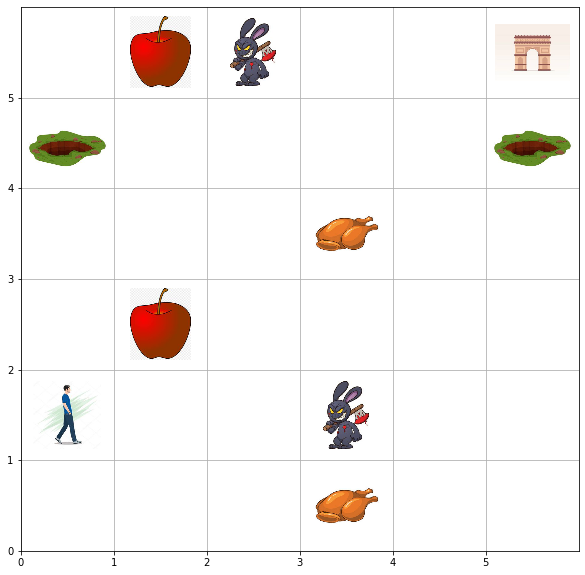

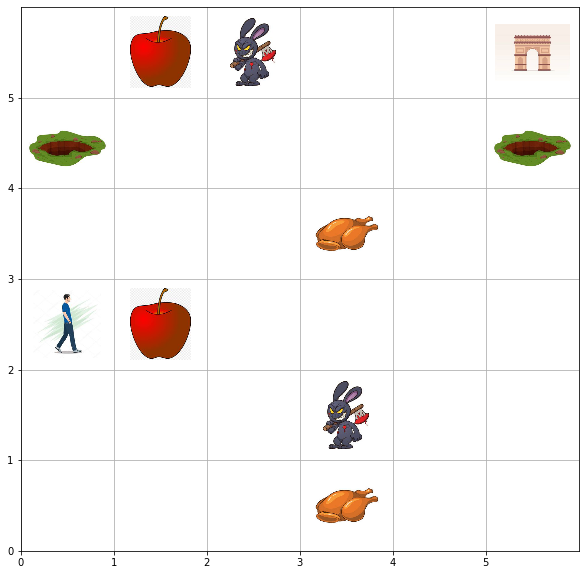

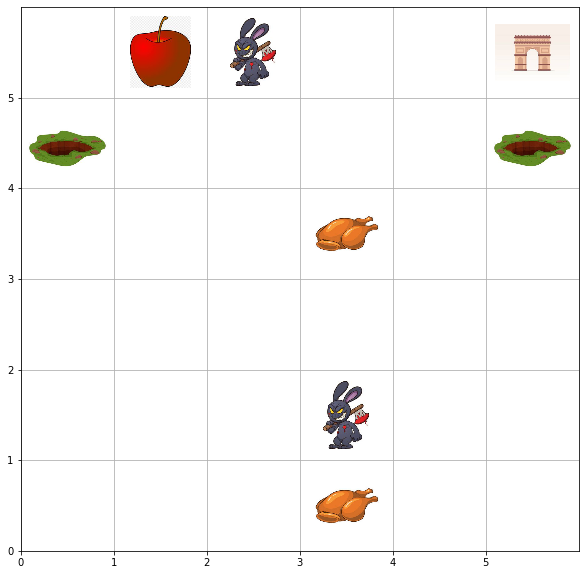

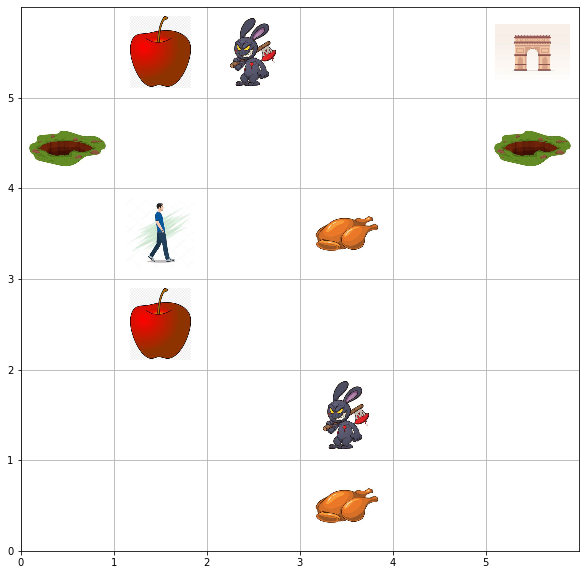

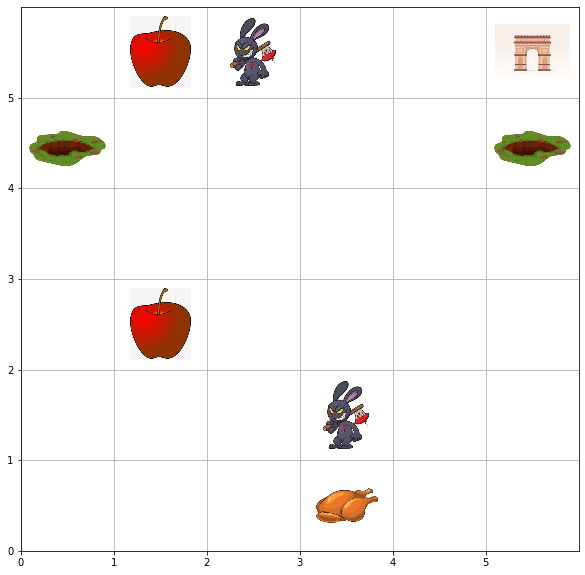

Evaluation Episode:3 -->Reward:-30.0
Mean Reward:-12.0


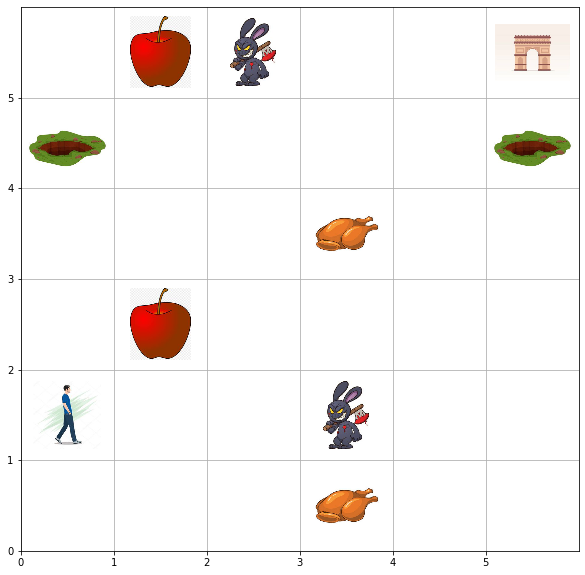

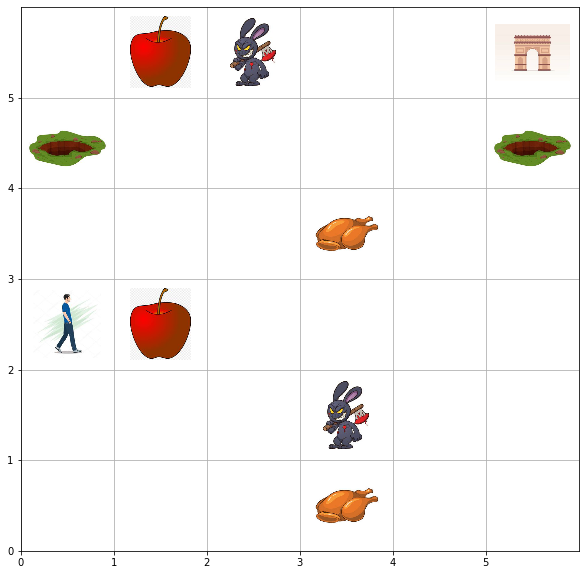

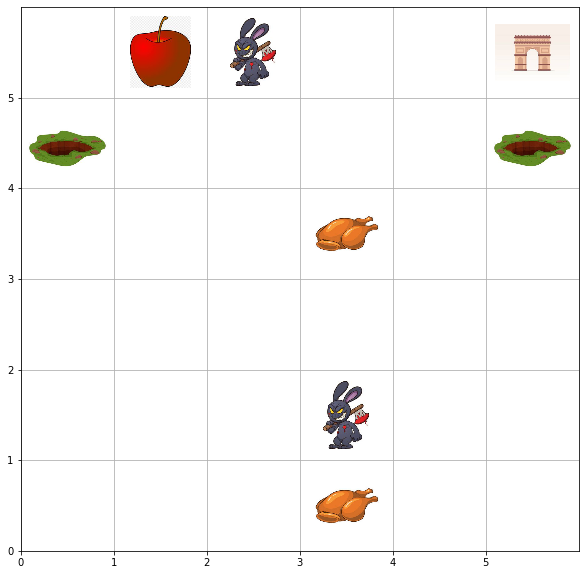

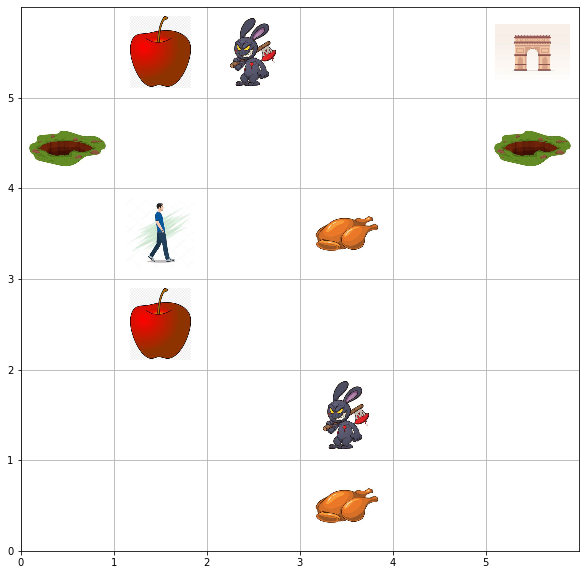

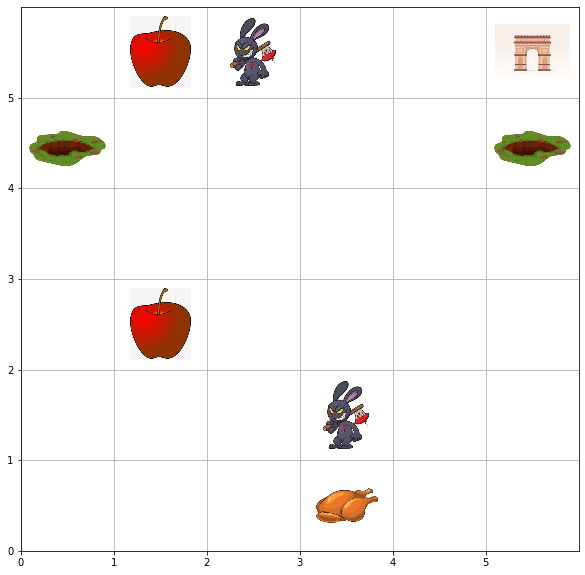

Evaluation Episode:4 -->Reward:-30.0
Mean Reward:-15.0


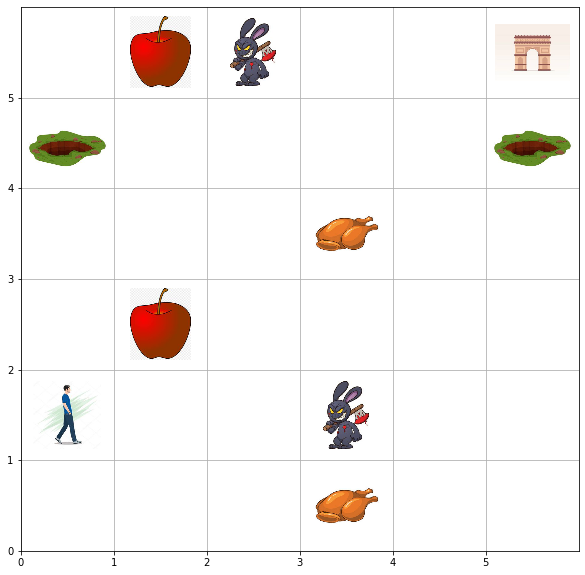

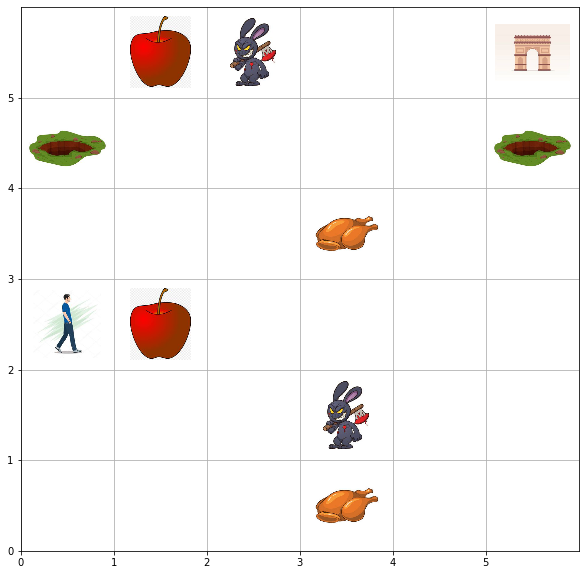

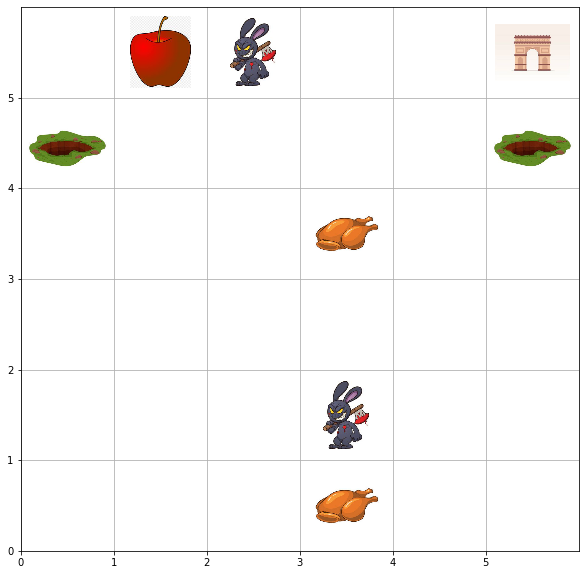

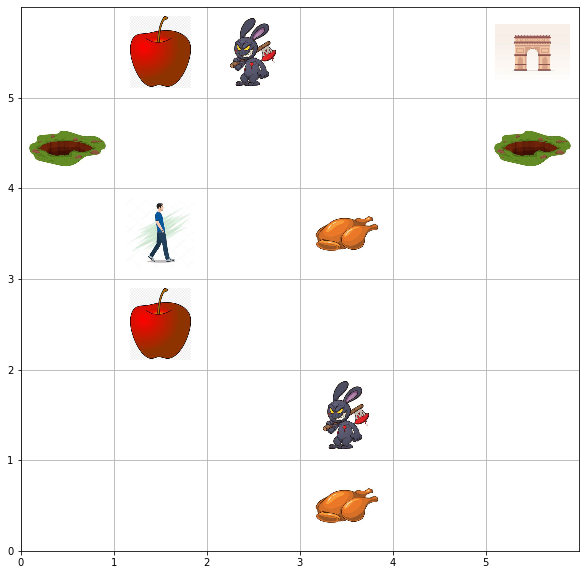

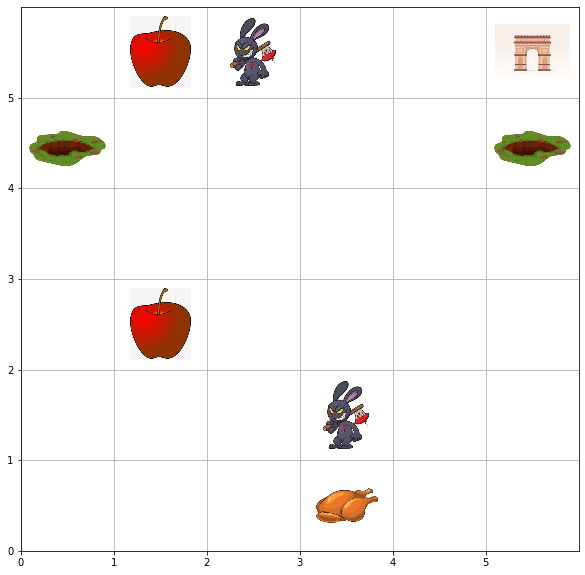

Evaluation Episode:5 -->Reward:-30.0
Mean Reward:-18.0


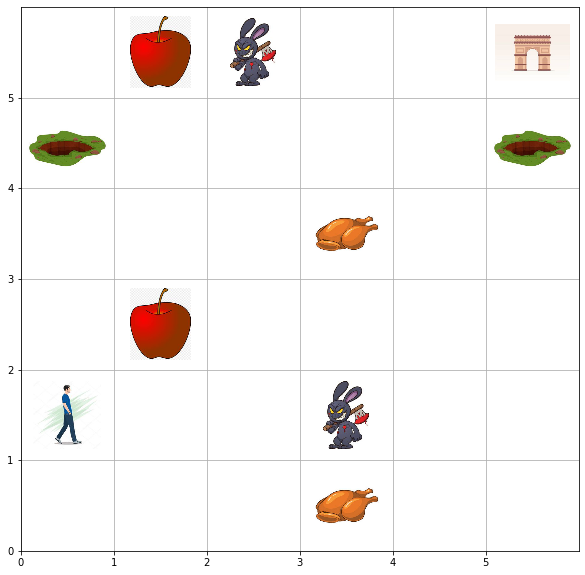

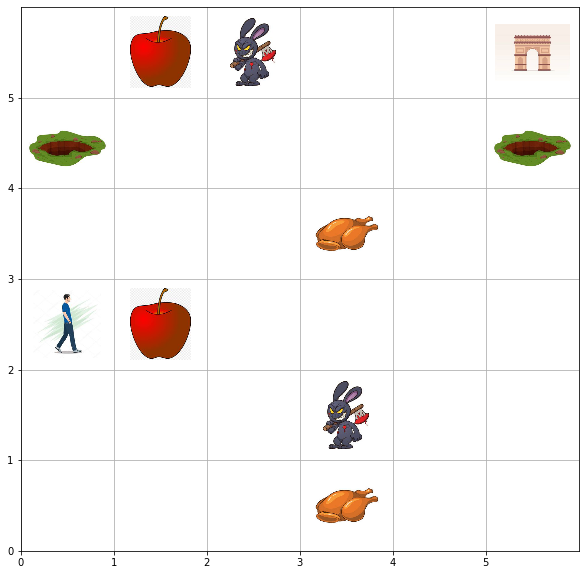

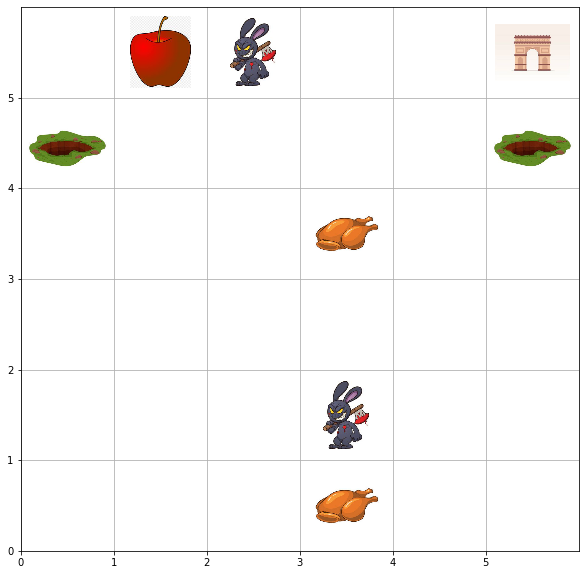

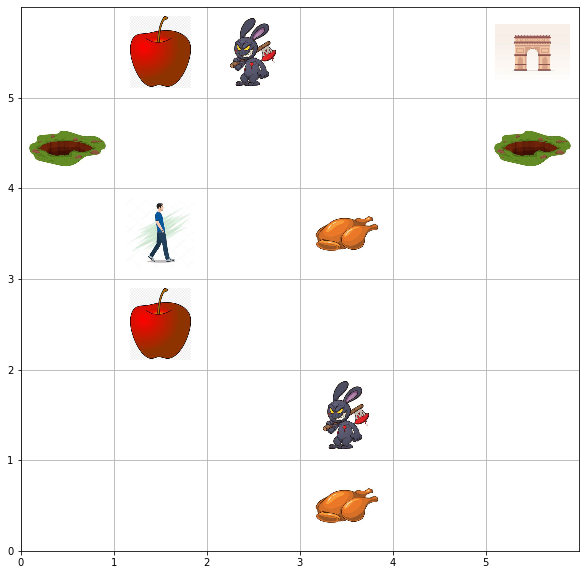

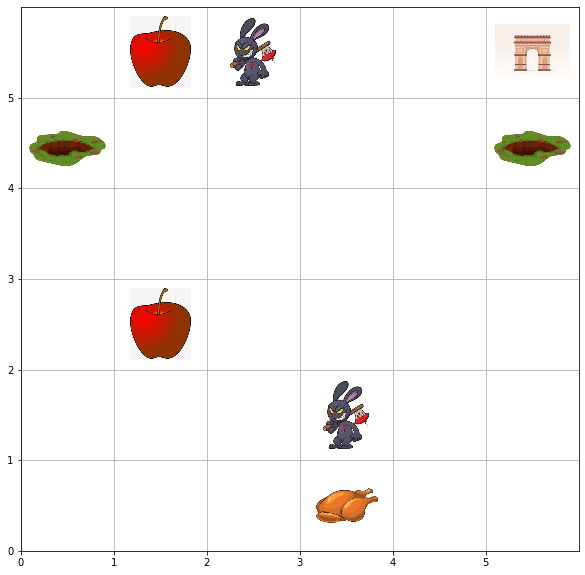

Evaluation Episode:6 -->Reward:-30.0
Mean Reward:-21.0


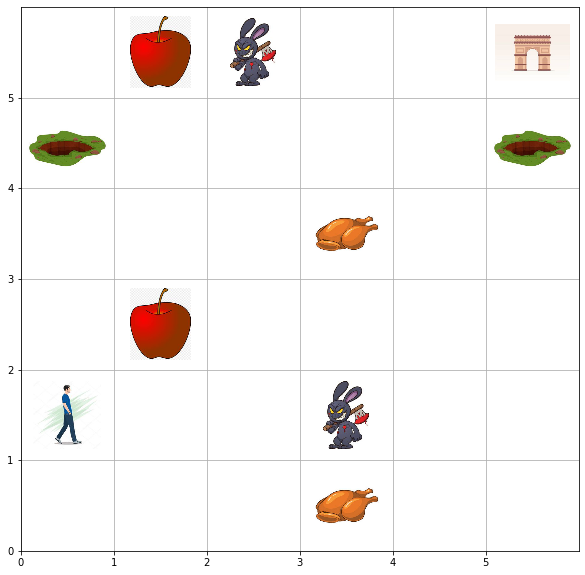

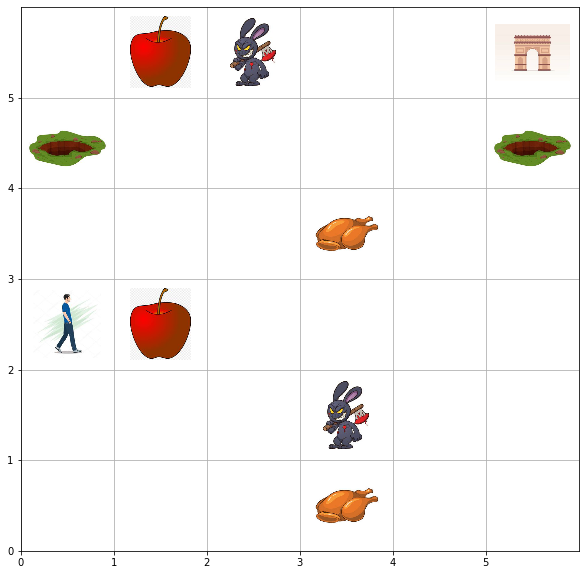

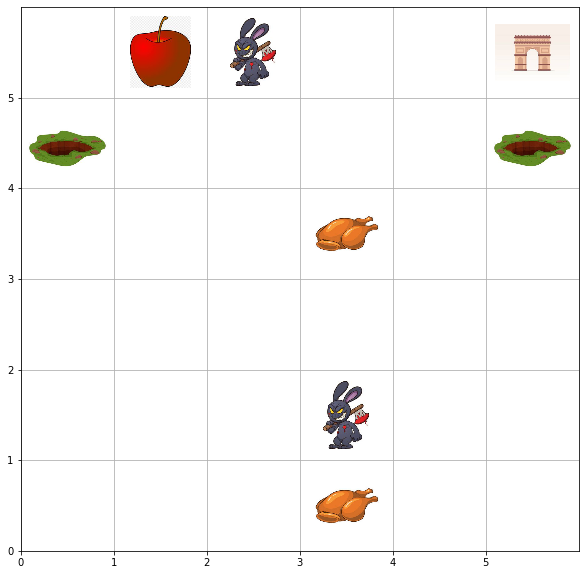

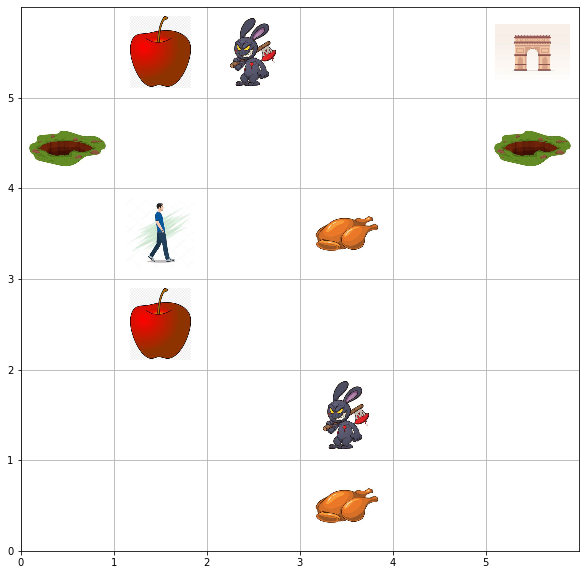

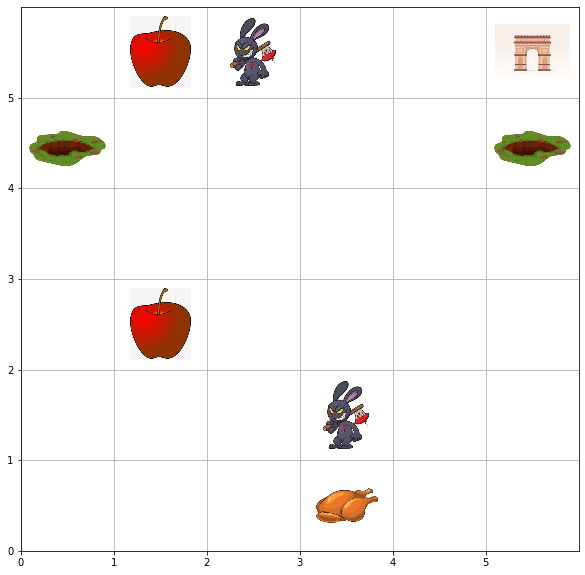

Evaluation Episode:7 -->Reward:-30.0
Mean Reward:-24.0


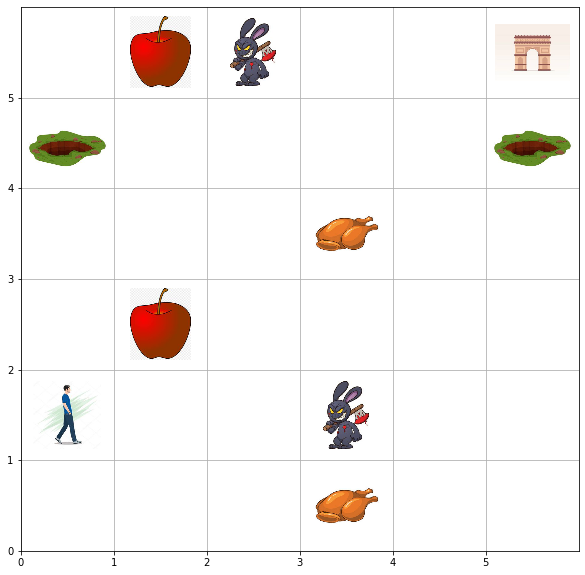

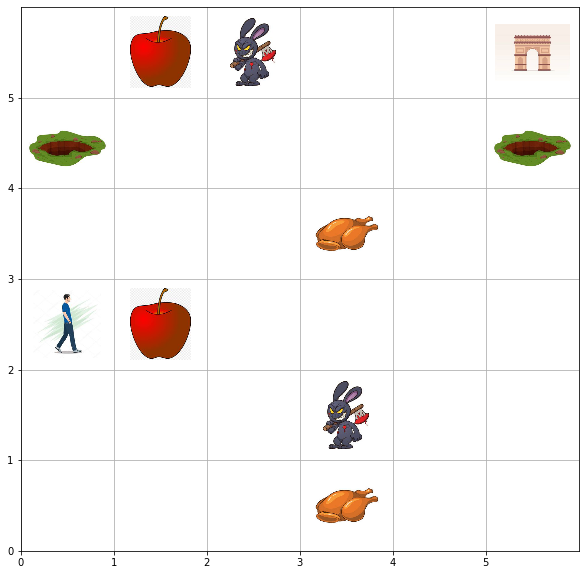

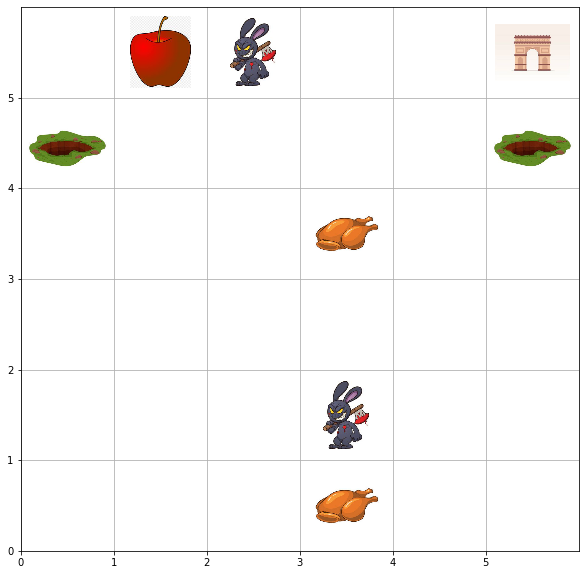

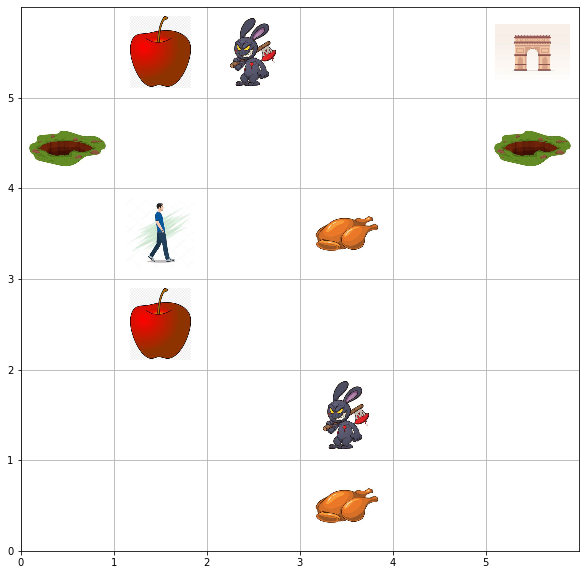

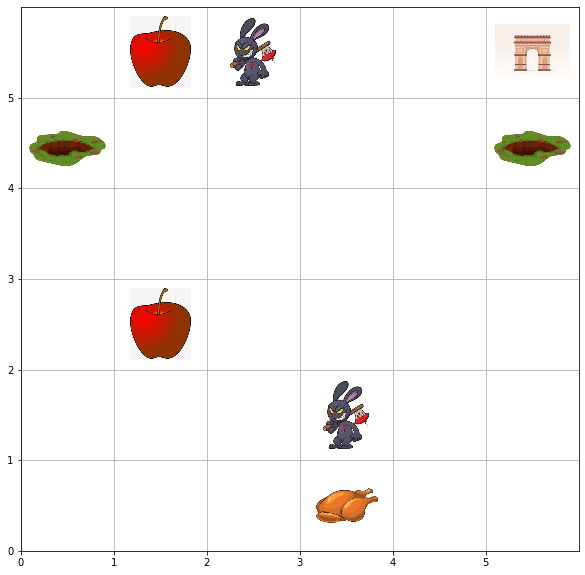

Evaluation Episode:8 -->Reward:-30.0
Mean Reward:-27.0


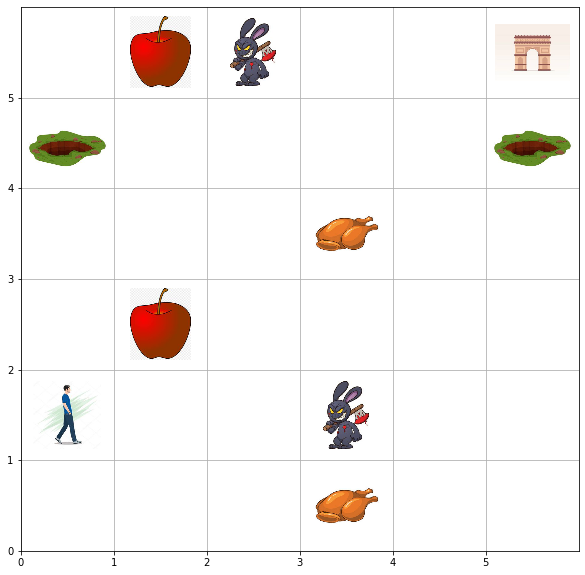

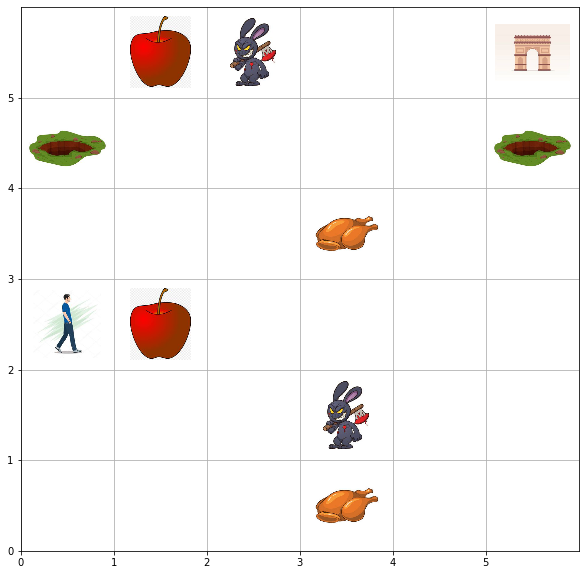

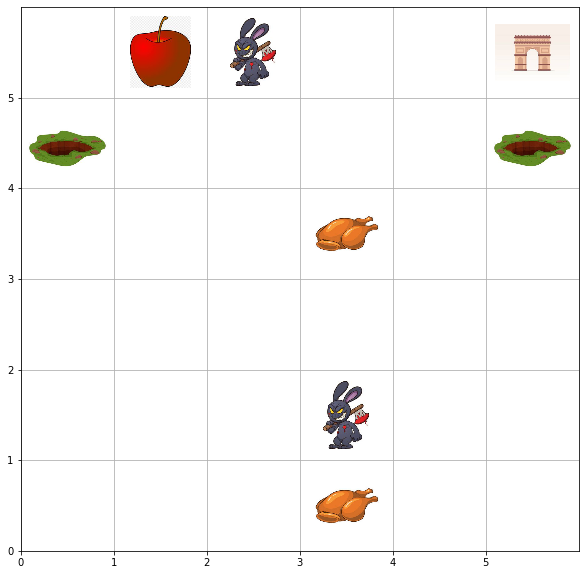

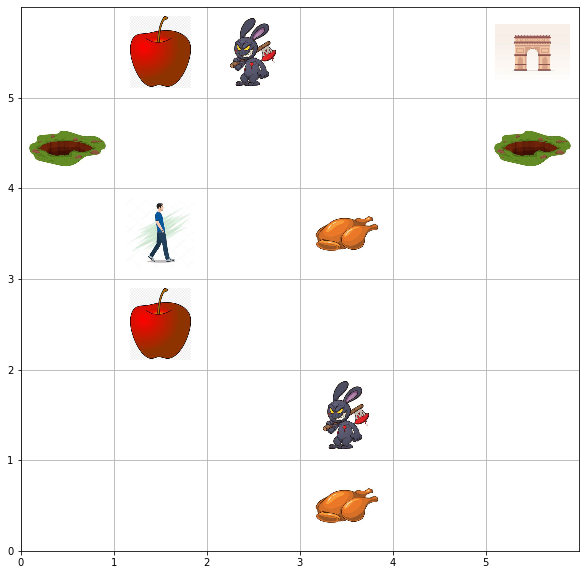

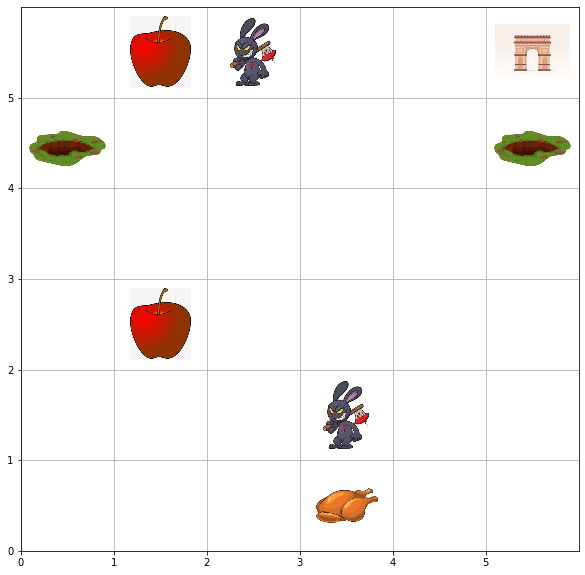

Evaluation Episode:9 -->Reward:-30.0
Mean Reward:-30.0


In [100]:
env.reset()
agentQL.epsilon=0.0 #greedy policy
total_episode=10
rewards= np.zeros((total_episode))
for i in range(total_episode):
    total_rewards=0
    s=env.reset()
    s=dict_res[tuple(env.agent_pos)]
    # print("s",s)
    for j in range(5):
      a =agentQL.action(s)
      a = np.clip(a, 0, 4)
      s_,r,done,_=env.step(a)
      s_=dict_res[tuple(env.agent_pos)]
      agentQL.update_QL(s,a,r,s_)
      env.render()
      s=s_
      total_rewards += r
      # print(a,s,s_,r)
      if done:
          # env.render()
          break

    rewards[i]=total_rewards
    print("Evaluation Episode:" +str(i) + " -->Reward:" +str(rewards[i]))
    print("Mean Reward:" +str(np.sum(rewards/total_episode)))

**SARSA** 

Initialize environment...

SARSA agent:


Episode 70 Reward -1295: 100%|██████████| 70/70 [00:03<00:00, 18.48it/s]


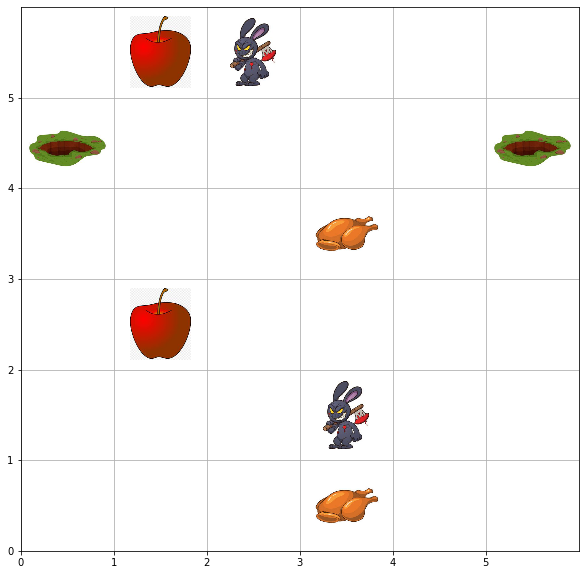

  0%|          | 0/70 [00:00<?, ?it/s]

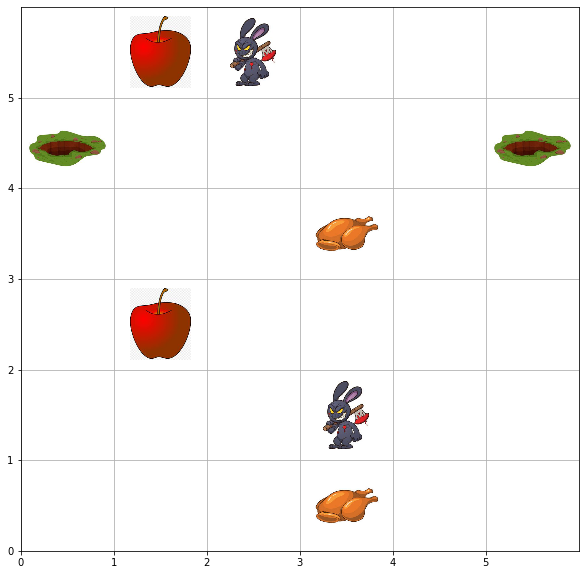

  1%|▏         | 1/70 [00:00<00:13,  5.01it/s]

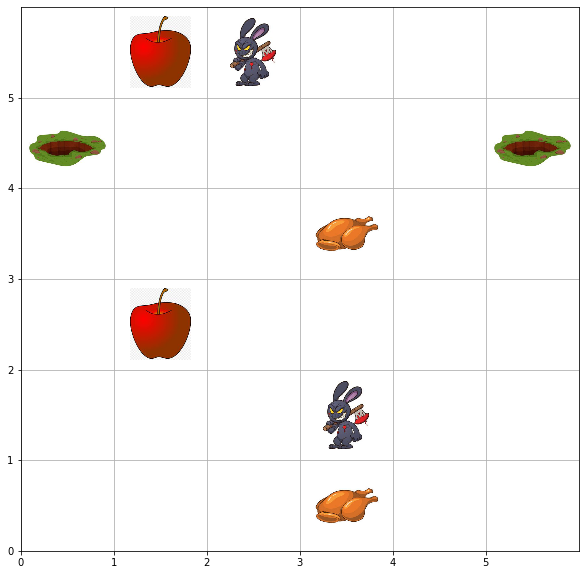

  3%|▎         | 2/70 [00:00<00:13,  4.97it/s]

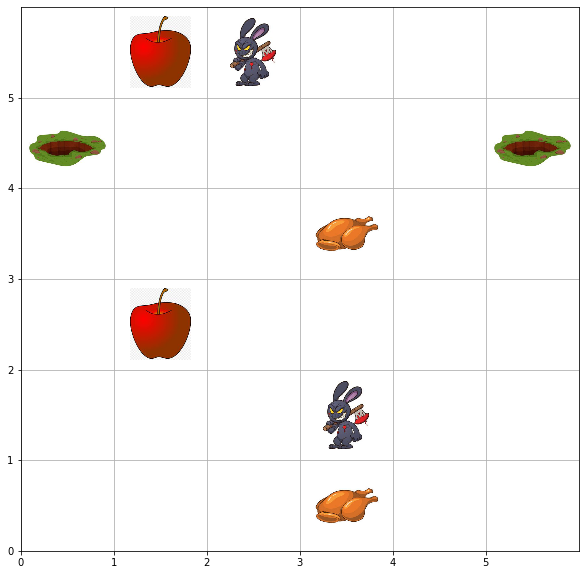

  4%|▍         | 3/70 [00:00<00:13,  4.92it/s]

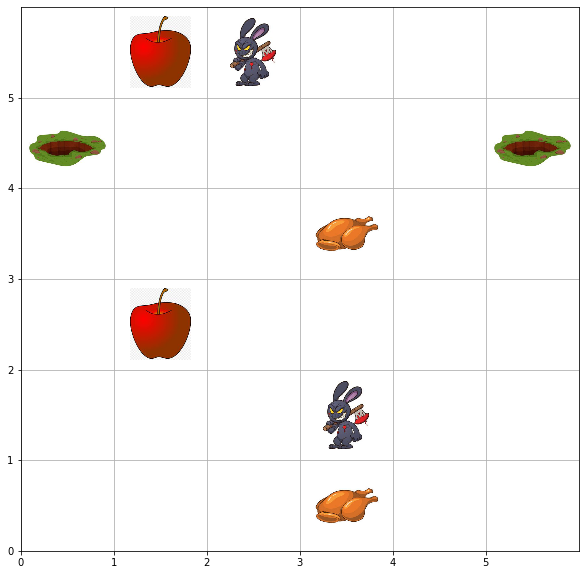

  6%|▌         | 4/70 [00:00<00:13,  4.88it/s]

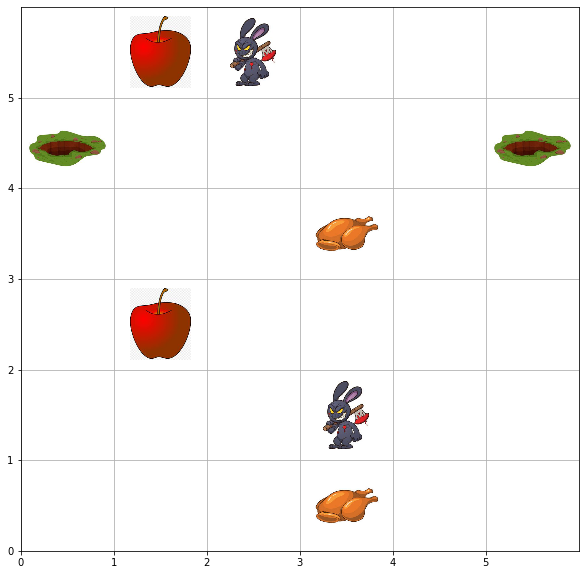

  7%|▋         | 5/70 [00:01<00:13,  4.84it/s]

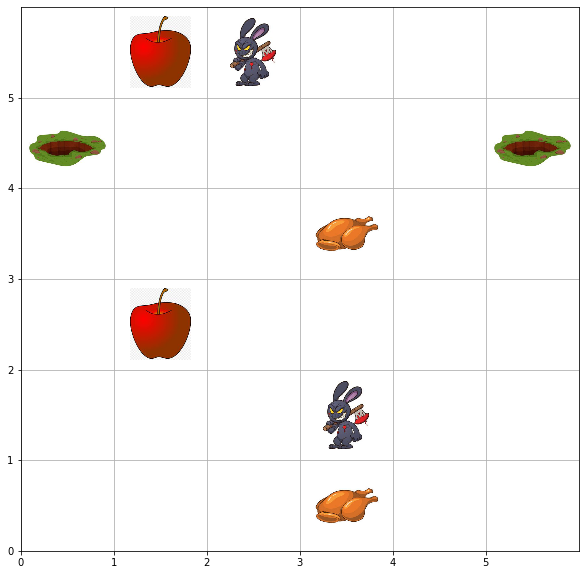

  9%|▊         | 6/70 [00:01<00:13,  4.76it/s]

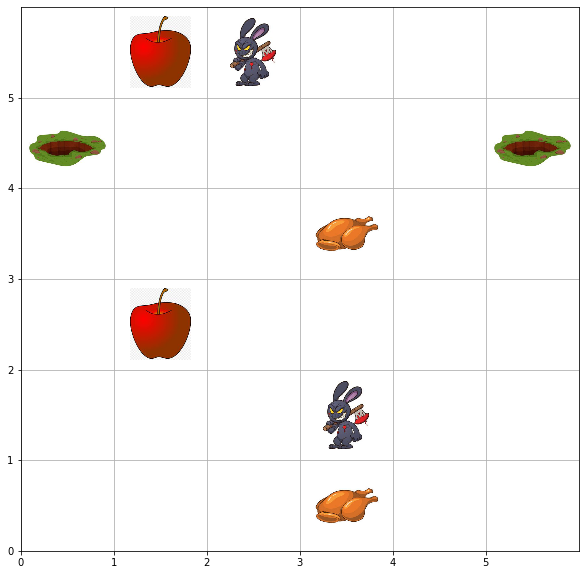

 10%|█         | 7/70 [00:01<00:13,  4.75it/s]

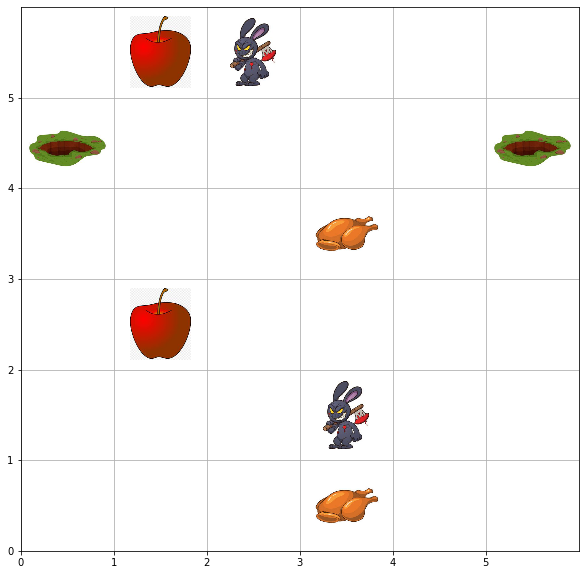

 11%|█▏        | 8/70 [00:01<00:13,  4.74it/s]

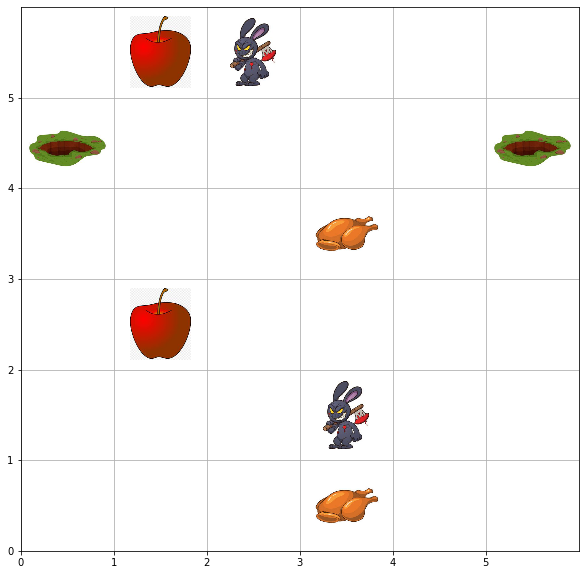

 13%|█▎        | 9/70 [00:01<00:14,  4.23it/s]

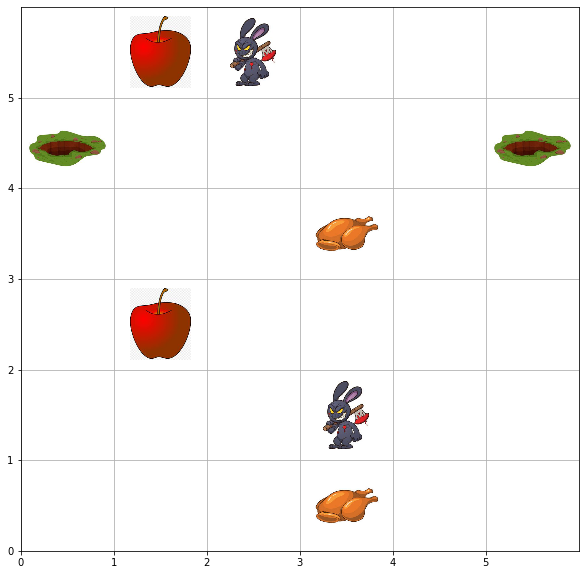

 14%|█▍        | 10/70 [00:02<00:13,  4.32it/s]

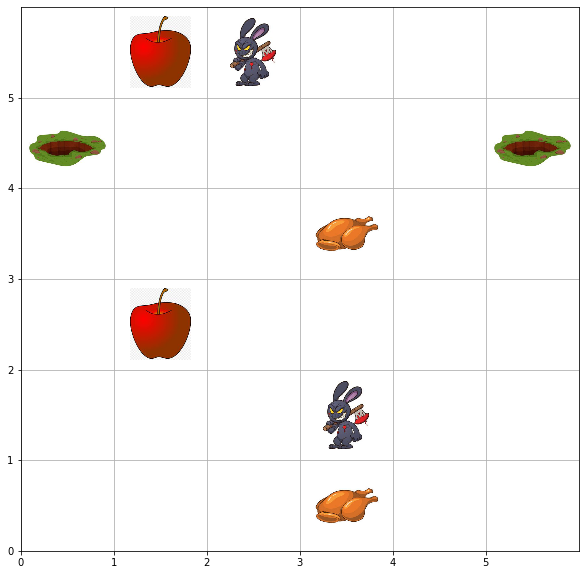

 16%|█▌        | 11/70 [00:02<00:13,  4.44it/s]

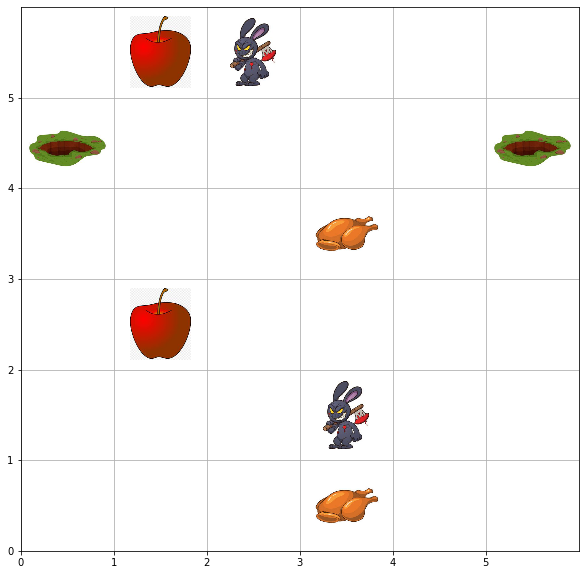

 17%|█▋        | 12/70 [00:02<00:12,  4.51it/s]

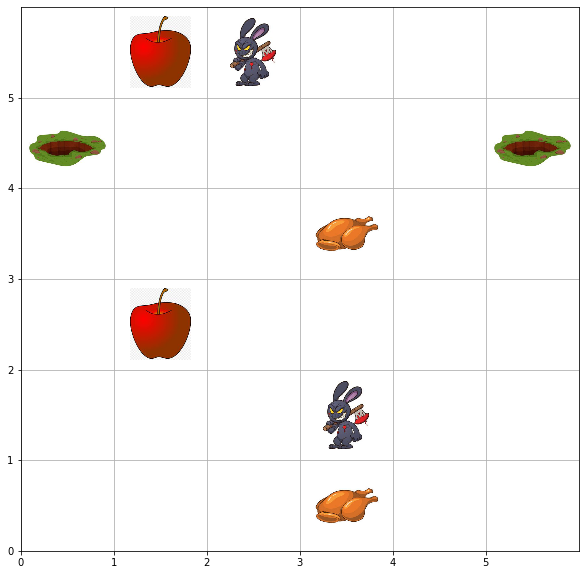

 19%|█▊        | 13/70 [00:02<00:12,  4.44it/s]

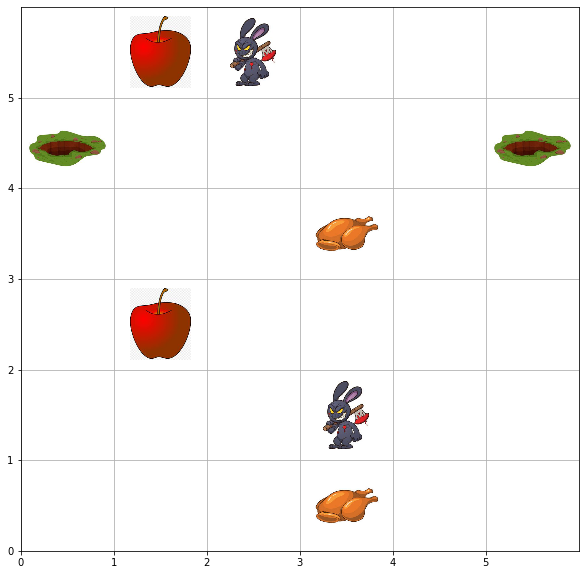

 20%|██        | 14/70 [00:03<00:12,  4.49it/s]

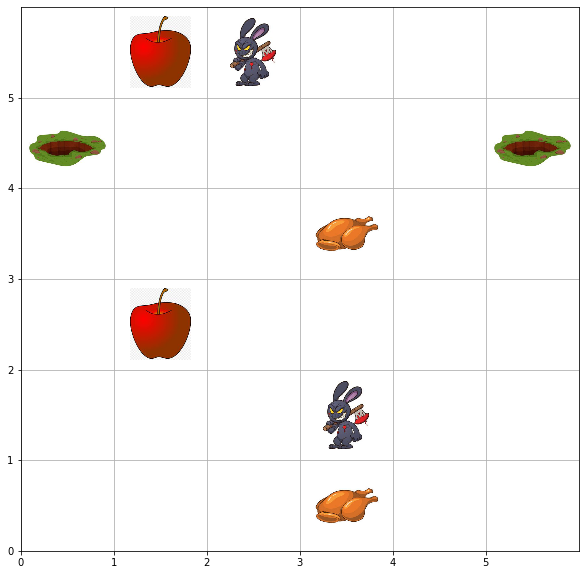

 21%|██▏       | 15/70 [00:03<00:12,  4.48it/s]

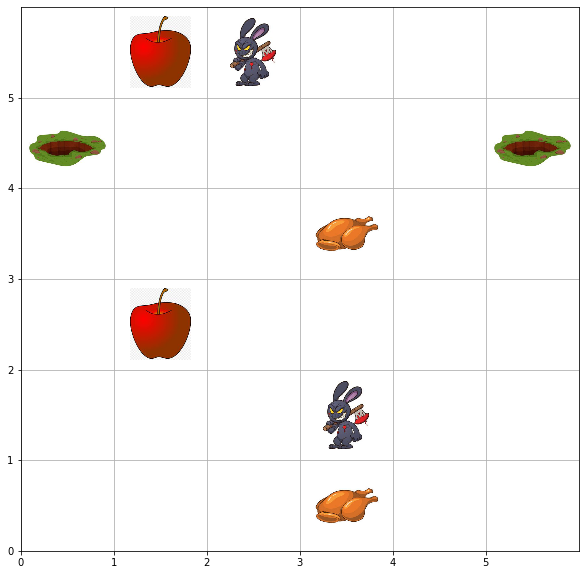

 23%|██▎       | 16/70 [00:03<00:11,  4.51it/s]

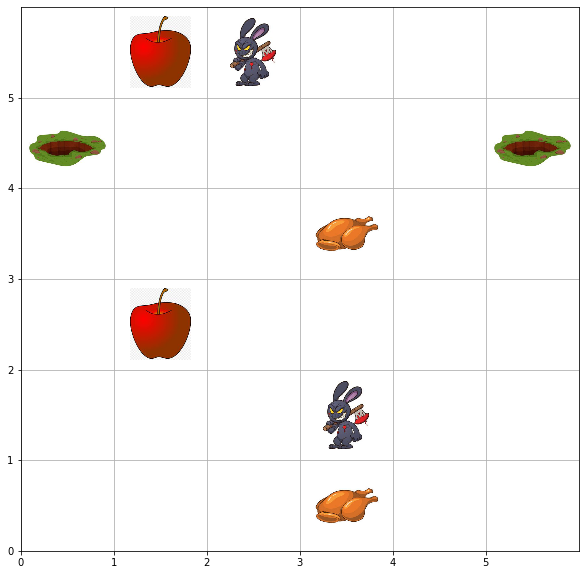

 24%|██▍       | 17/70 [00:03<00:11,  4.54it/s]

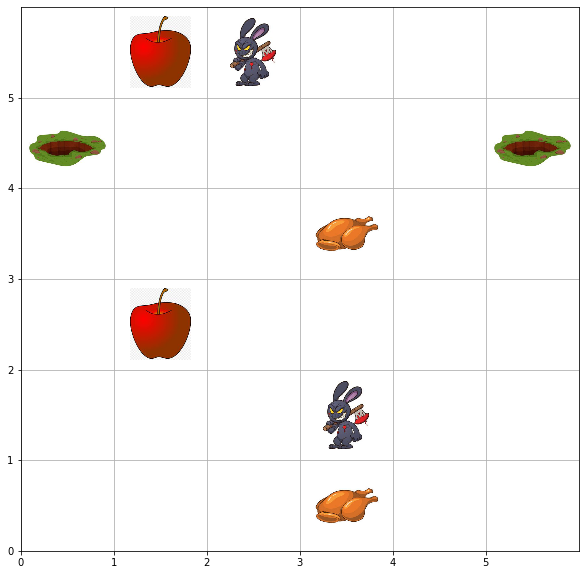

 26%|██▌       | 18/70 [00:04<00:12,  4.16it/s]

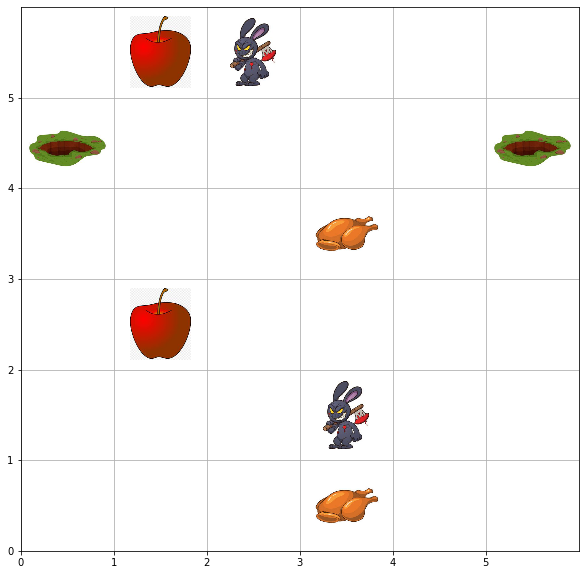

 27%|██▋       | 19/70 [00:04<00:13,  3.77it/s]

 29%|██▊       | 20/70 [00:04<00:13,  3.60it/s]

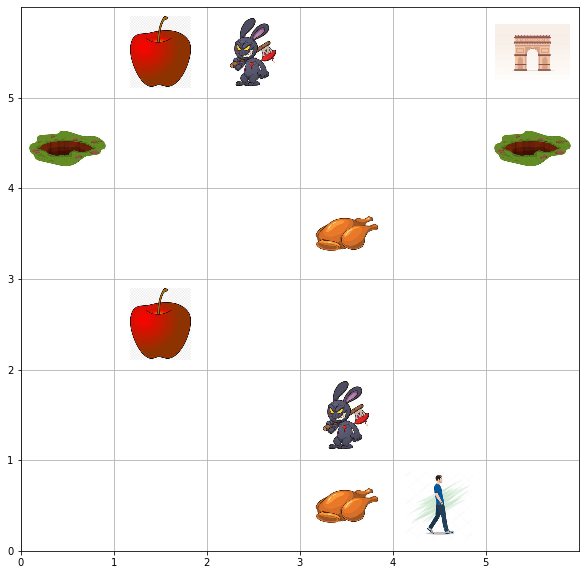

 30%|███       | 21/70 [00:04<00:13,  3.69it/s]

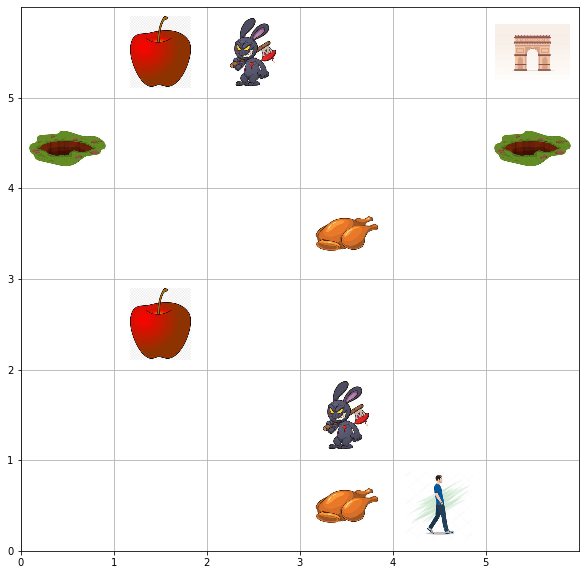

 31%|███▏      | 22/70 [00:05<00:12,  3.73it/s]

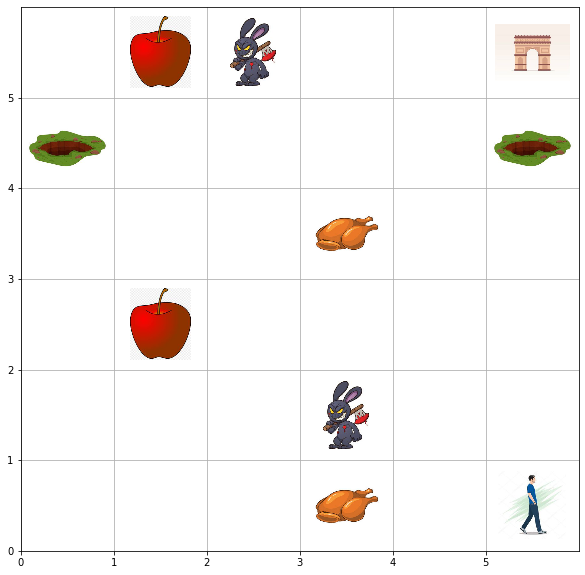

 33%|███▎      | 23/70 [00:05<00:12,  3.81it/s]

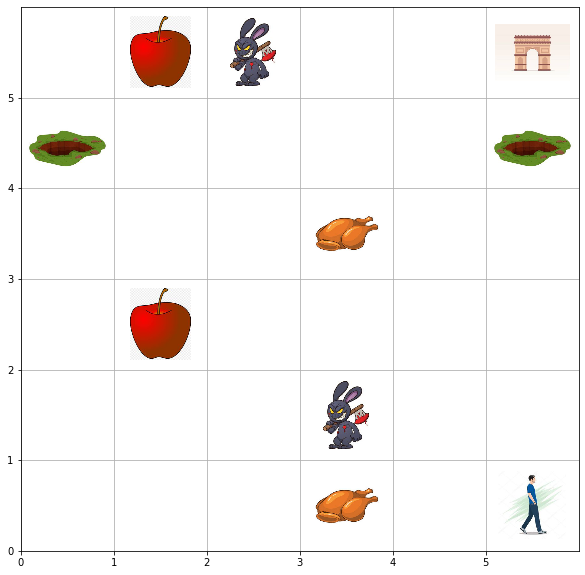

 34%|███▍      | 24/70 [00:05<00:11,  3.85it/s]

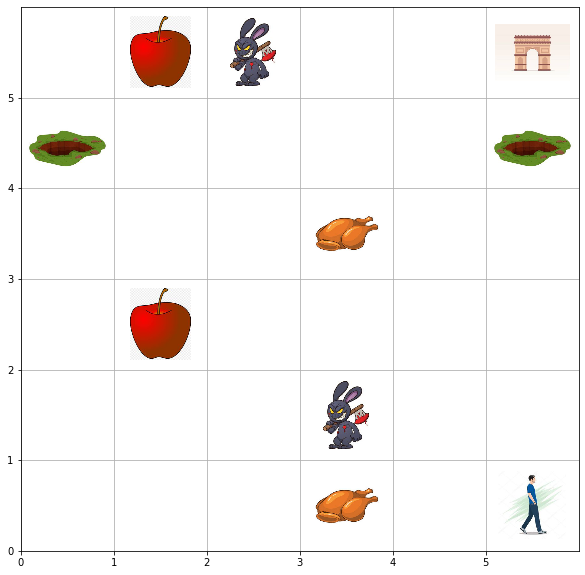

 36%|███▌      | 25/70 [00:05<00:12,  3.69it/s]

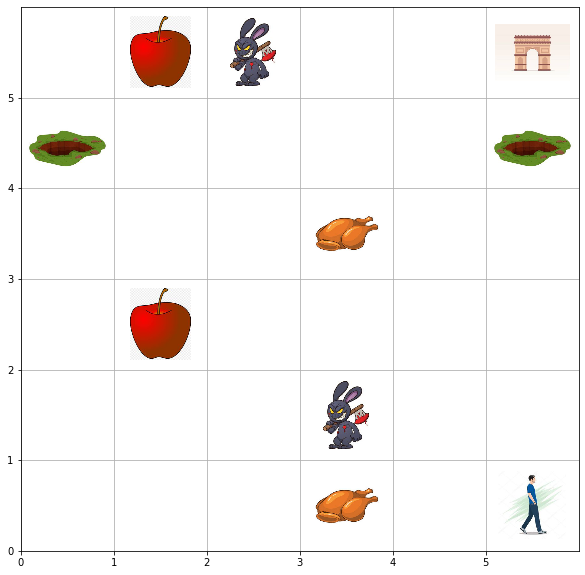

 37%|███▋      | 26/70 [00:06<00:11,  3.73it/s]

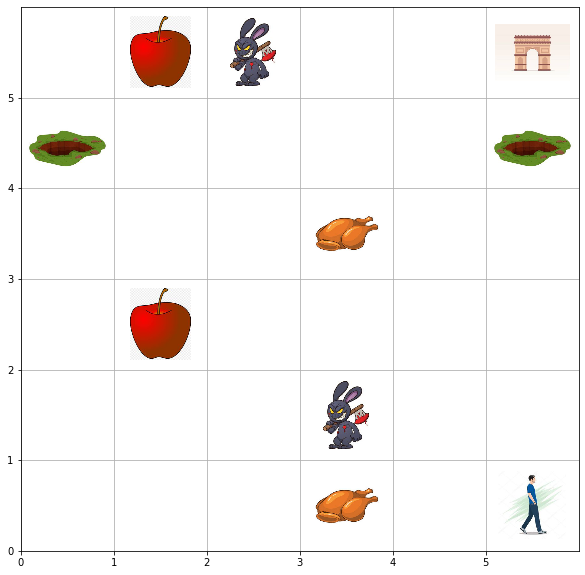

 39%|███▊      | 27/70 [00:06<00:11,  3.76it/s]

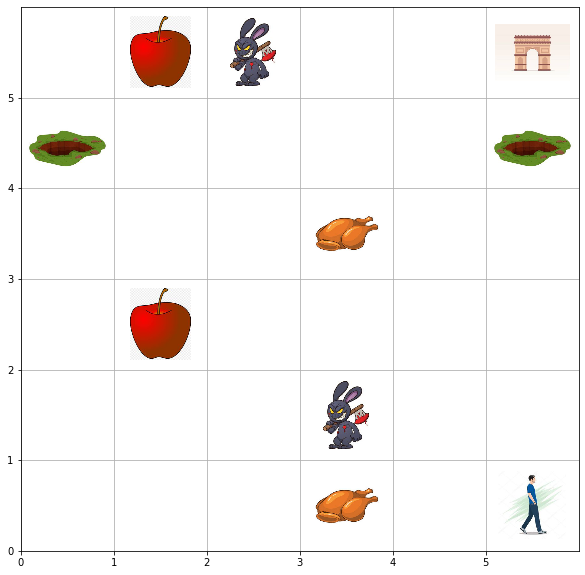

 40%|████      | 28/70 [00:06<00:11,  3.78it/s]

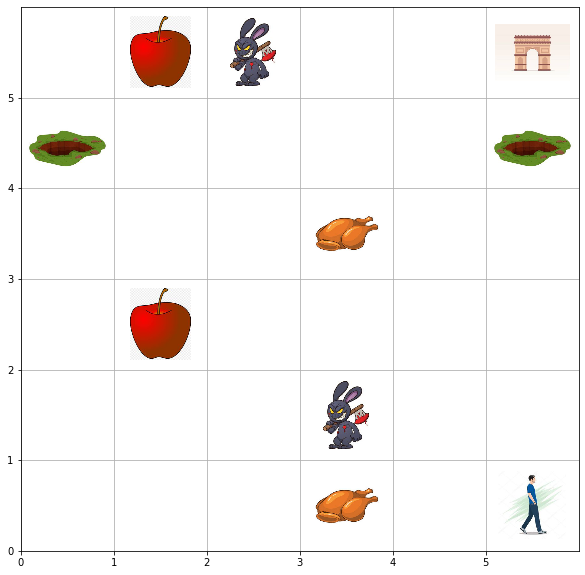

 41%|████▏     | 29/70 [00:07<00:10,  3.74it/s]

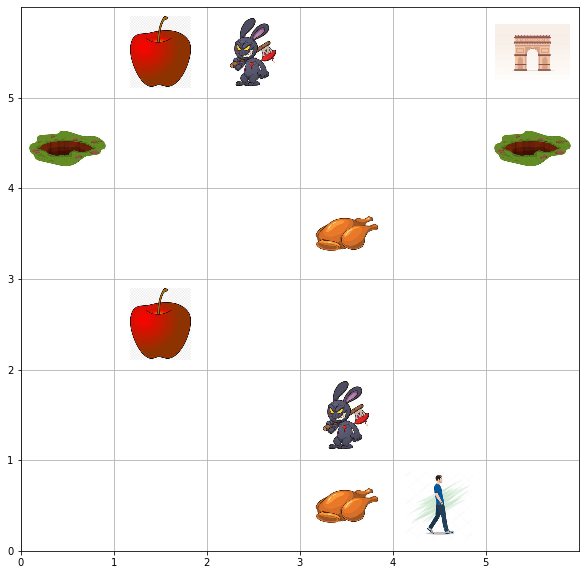

 43%|████▎     | 30/70 [00:07<00:10,  3.77it/s]

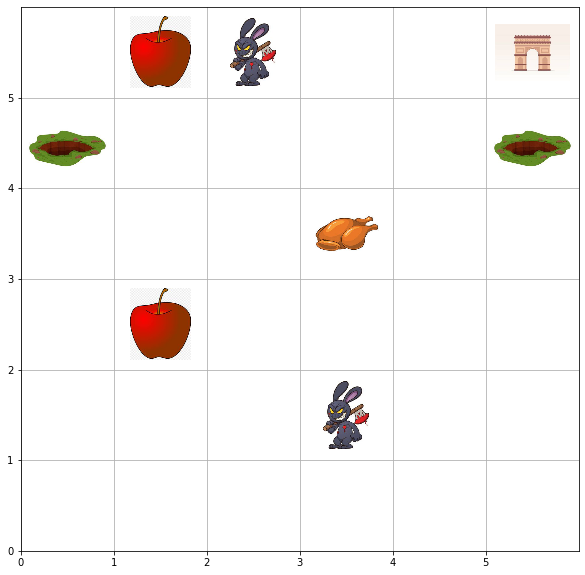

 44%|████▍     | 31/70 [00:07<00:10,  3.68it/s]

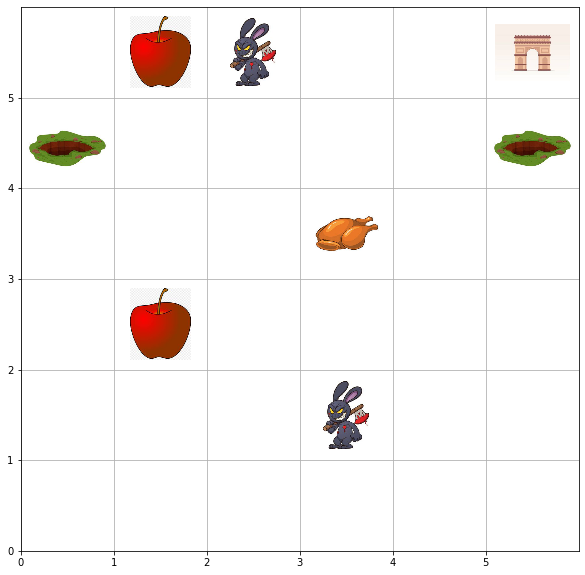

 46%|████▌     | 32/70 [00:07<00:09,  3.82it/s]

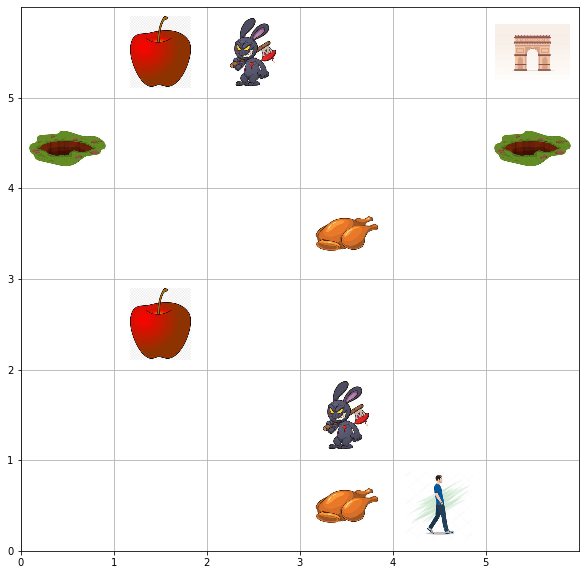

 47%|████▋     | 33/70 [00:08<00:09,  3.76it/s]

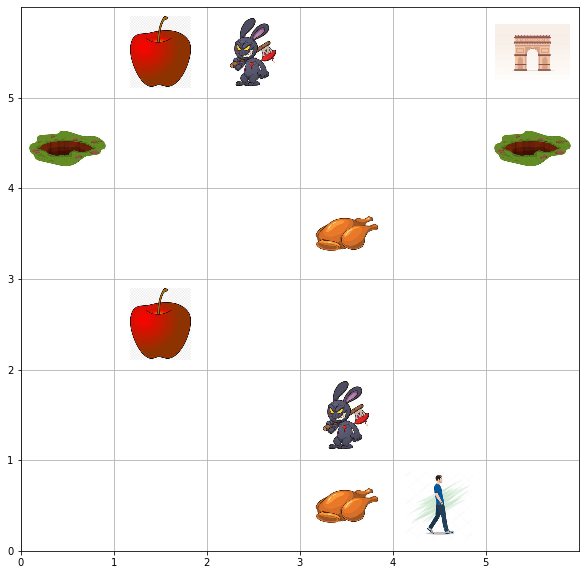

 49%|████▊     | 34/70 [00:08<00:09,  3.74it/s]

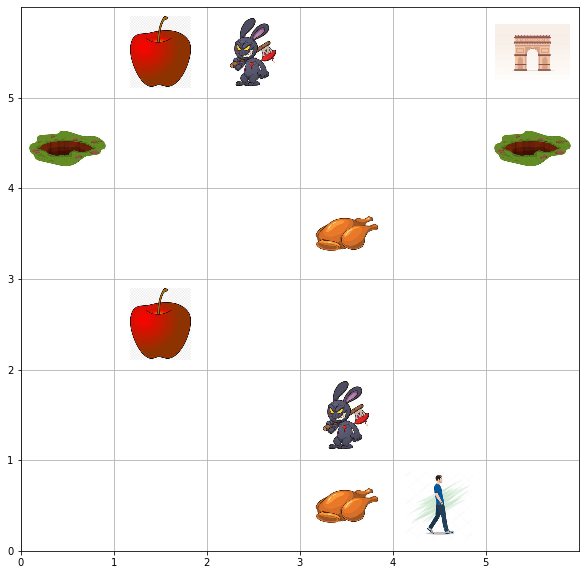

 50%|█████     | 35/70 [00:08<00:09,  3.71it/s]

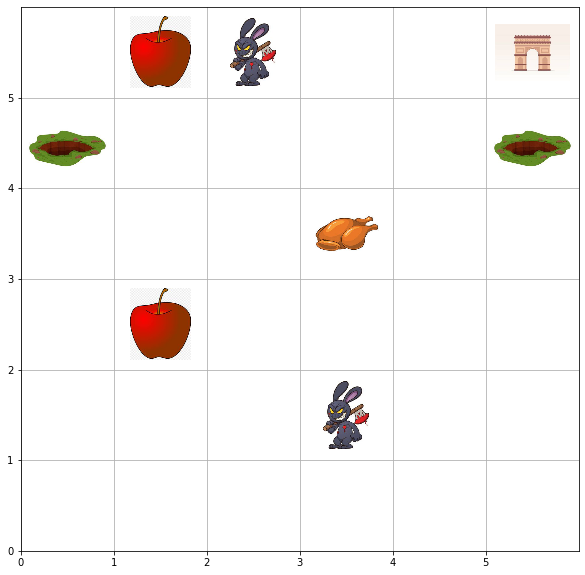

 51%|█████▏    | 36/70 [00:08<00:08,  3.84it/s]

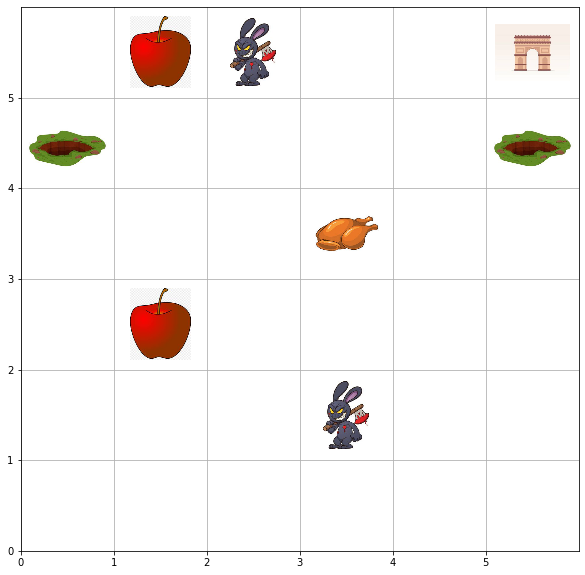

 53%|█████▎    | 37/70 [00:09<00:08,  3.85it/s]

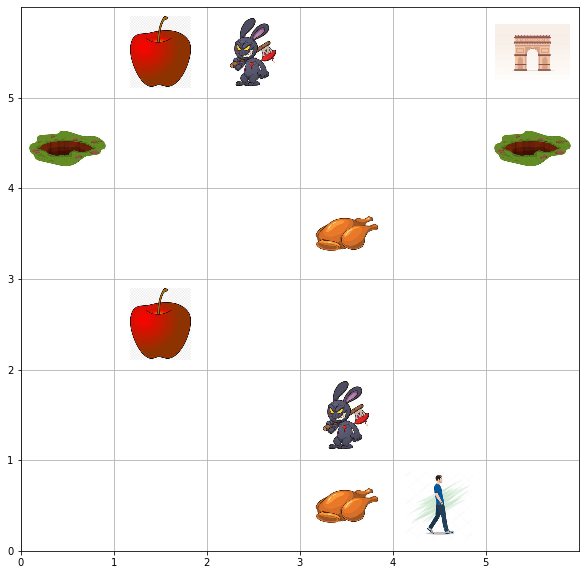

 54%|█████▍    | 38/70 [00:09<00:08,  3.79it/s]

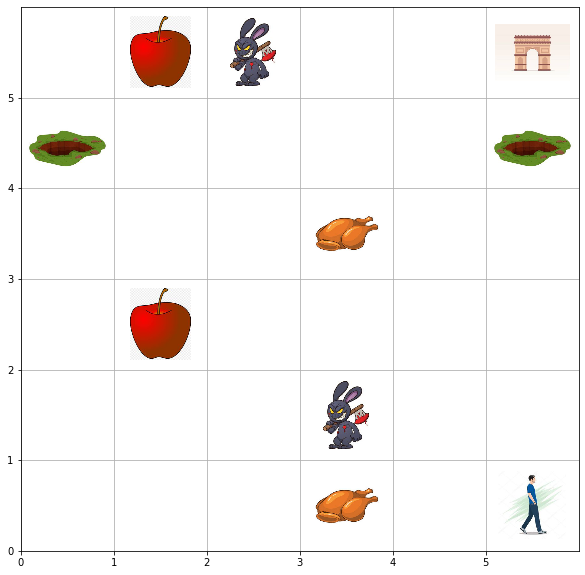

 56%|█████▌    | 39/70 [00:09<00:08,  3.72it/s]

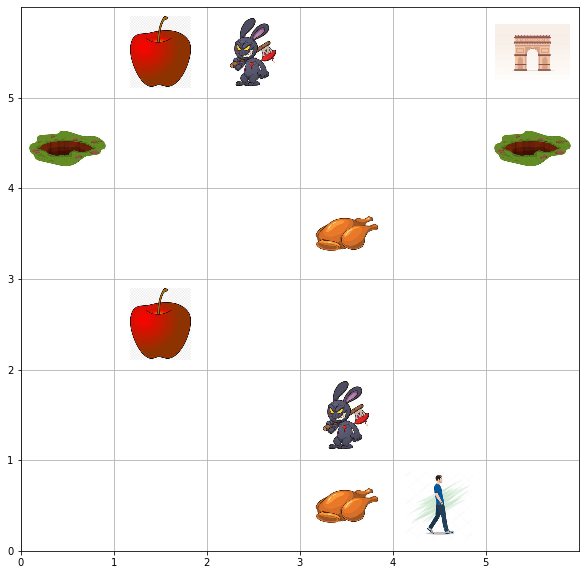

 57%|█████▋    | 40/70 [00:09<00:08,  3.66it/s]

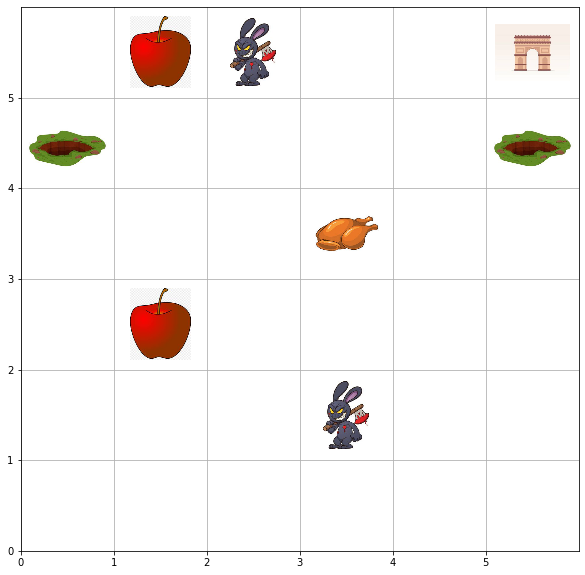

 59%|█████▊    | 41/70 [00:10<00:07,  3.72it/s]

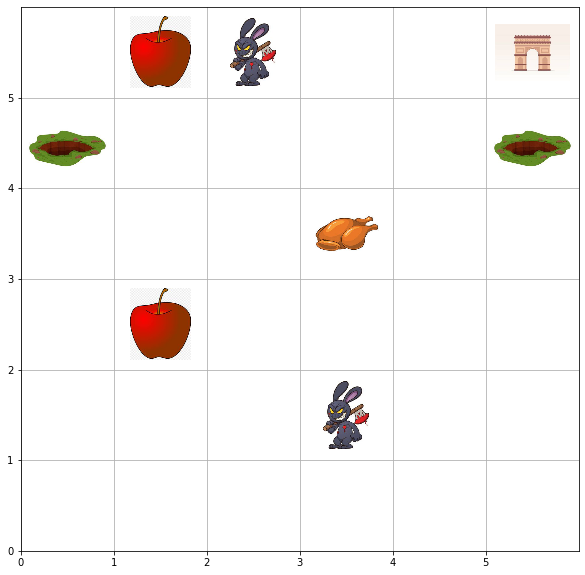

 60%|██████    | 42/70 [00:10<00:07,  3.59it/s]

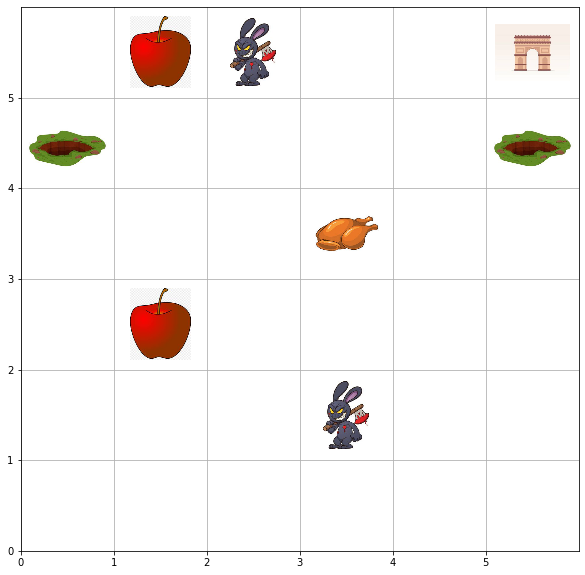

 61%|██████▏   | 43/70 [00:10<00:07,  3.63it/s]

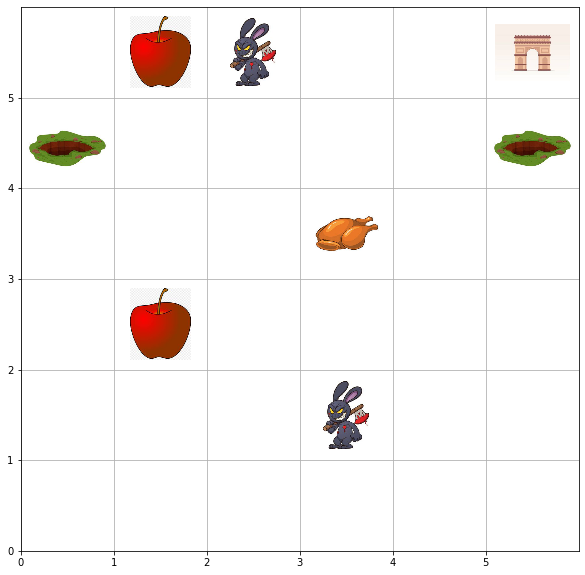

 63%|██████▎   | 44/70 [00:11<00:07,  3.67it/s]

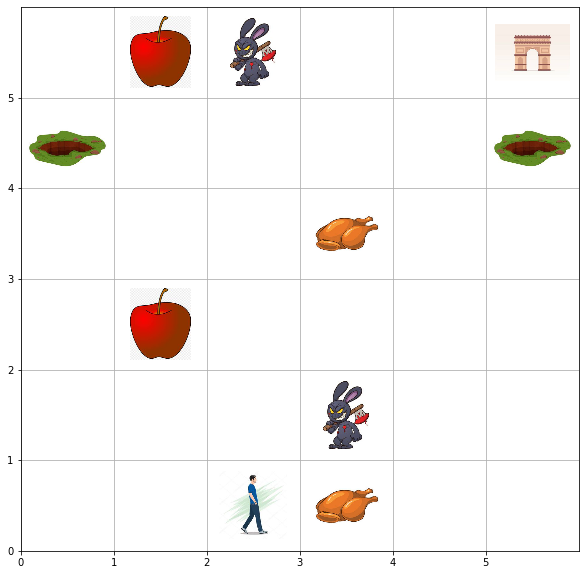

 64%|██████▍   | 45/70 [00:11<00:06,  3.62it/s]

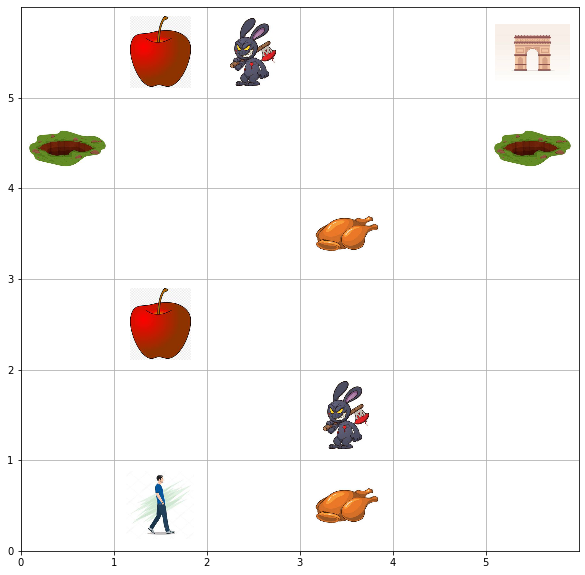

 66%|██████▌   | 46/70 [00:11<00:06,  3.57it/s]

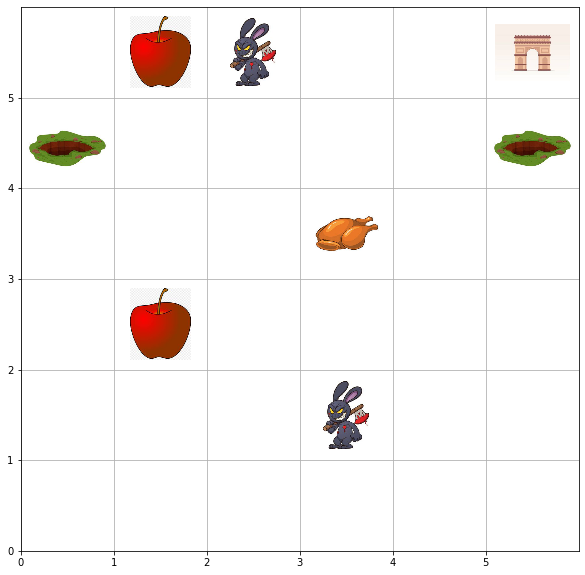

 67%|██████▋   | 47/70 [00:11<00:06,  3.63it/s]

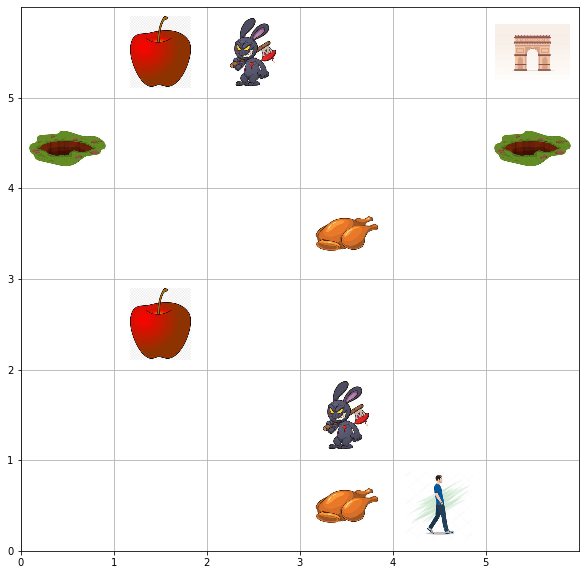

 69%|██████▊   | 48/70 [00:12<00:06,  3.56it/s]

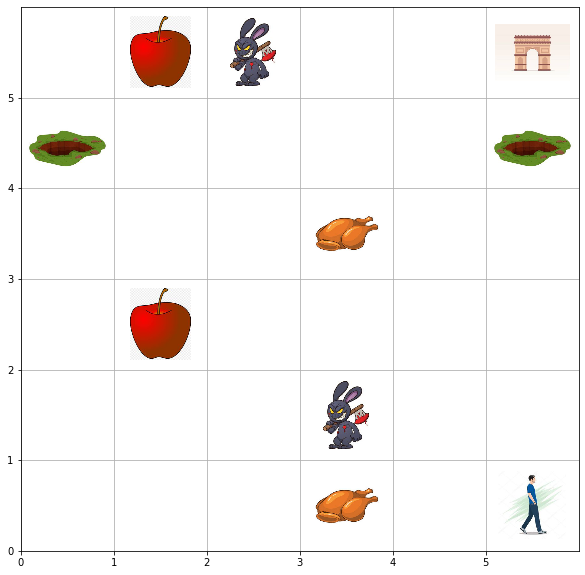

 70%|███████   | 49/70 [00:12<00:05,  3.54it/s]

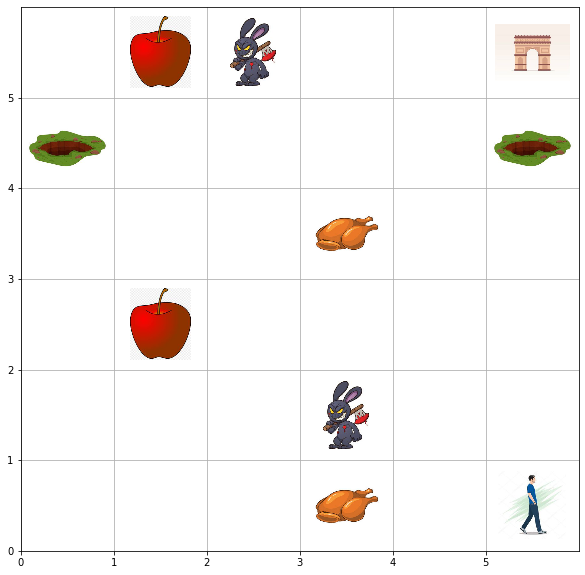

 71%|███████▏  | 50/70 [00:12<00:05,  3.53it/s]

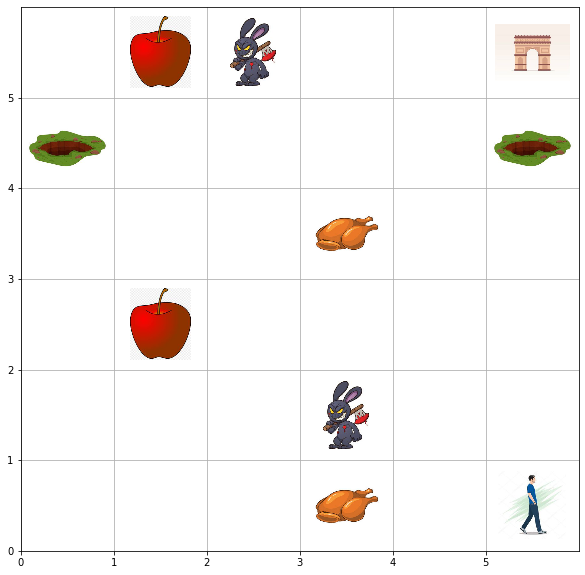

 73%|███████▎  | 51/70 [00:13<00:05,  3.49it/s]

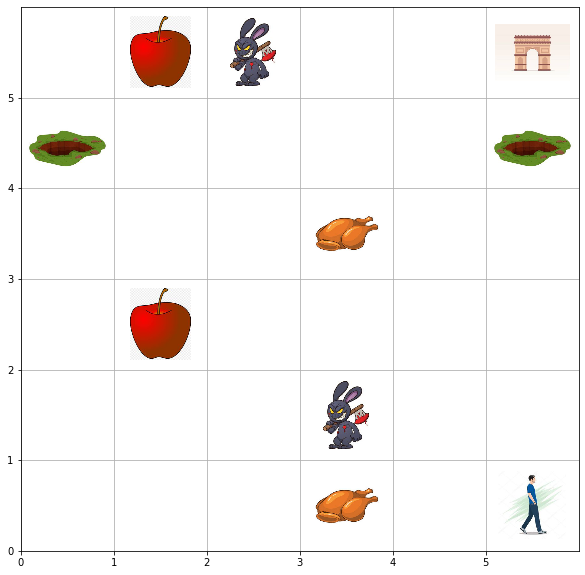

 74%|███████▍  | 52/70 [00:13<00:05,  3.43it/s]

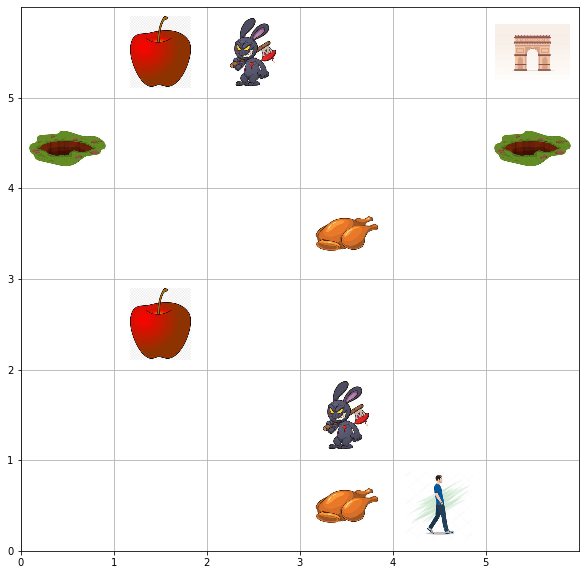

 76%|███████▌  | 53/70 [00:13<00:05,  3.28it/s]

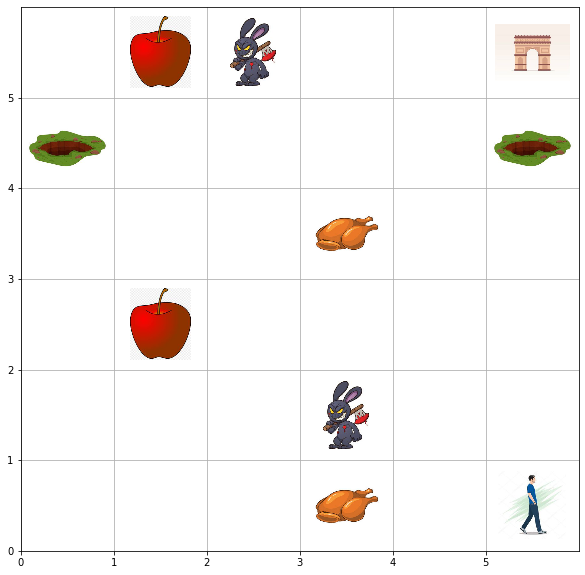

 77%|███████▋  | 54/70 [00:13<00:04,  3.30it/s]

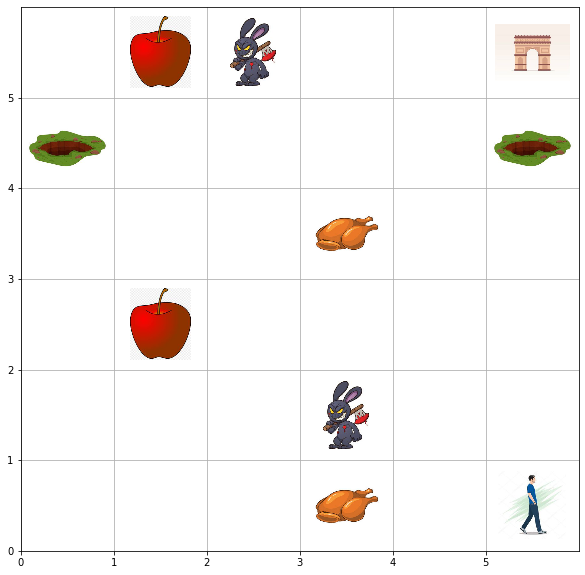

 79%|███████▊  | 55/70 [00:14<00:04,  3.24it/s]

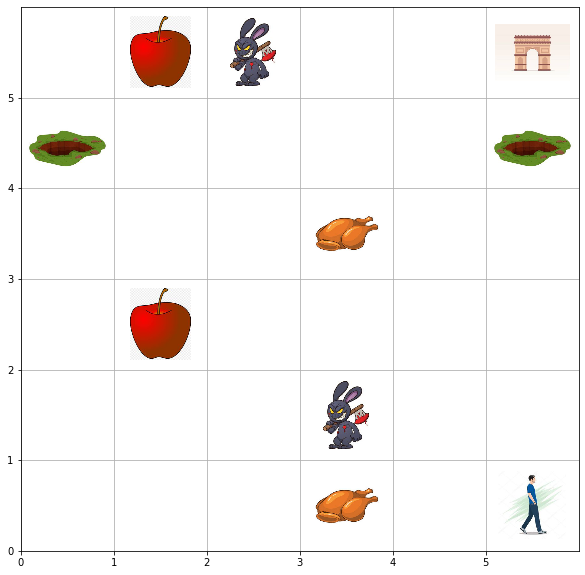

 80%|████████  | 56/70 [00:14<00:04,  3.24it/s]

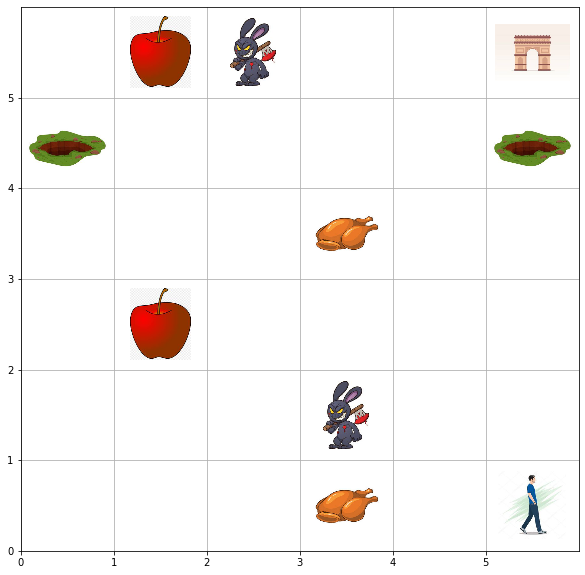

 81%|████████▏ | 57/70 [00:14<00:04,  3.22it/s]

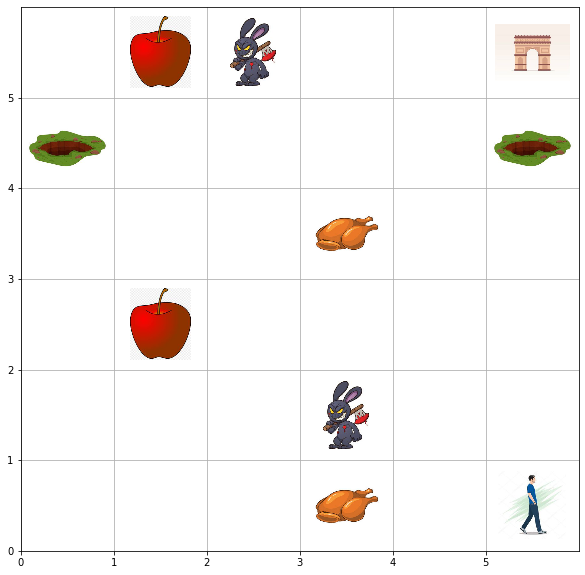

 83%|████████▎ | 58/70 [00:15<00:03,  3.20it/s]

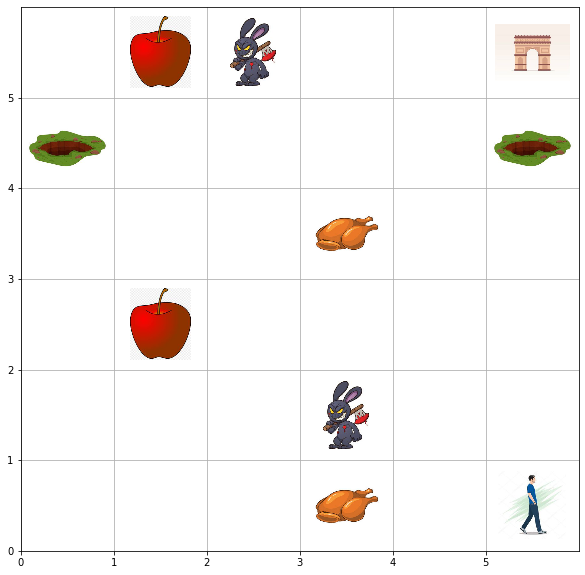

 84%|████████▍ | 59/70 [00:15<00:03,  3.19it/s]

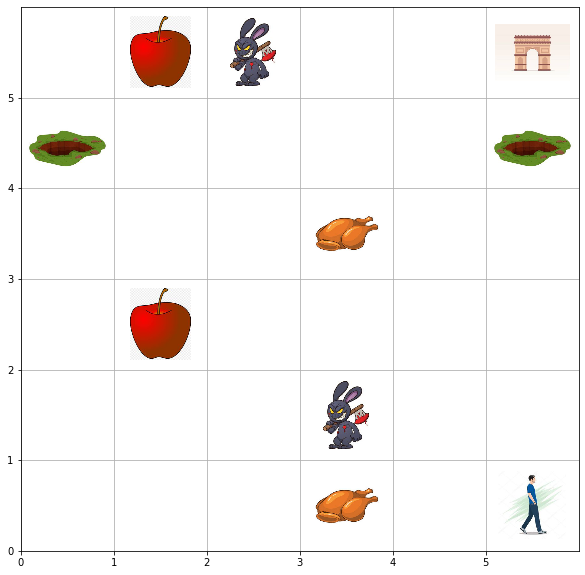

 86%|████████▌ | 60/70 [00:15<00:03,  3.16it/s]

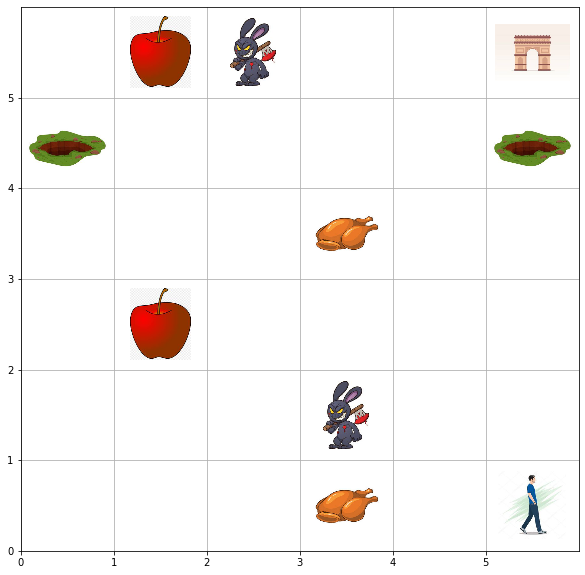

 87%|████████▋ | 61/70 [00:16<00:02,  3.07it/s]

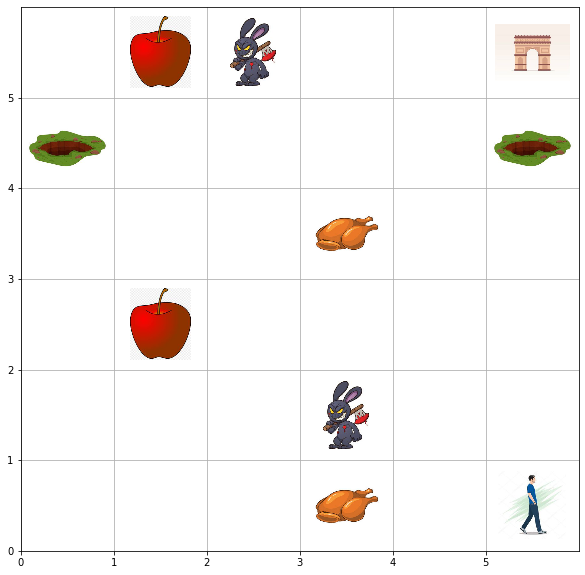

 89%|████████▊ | 62/70 [00:16<00:02,  3.08it/s]

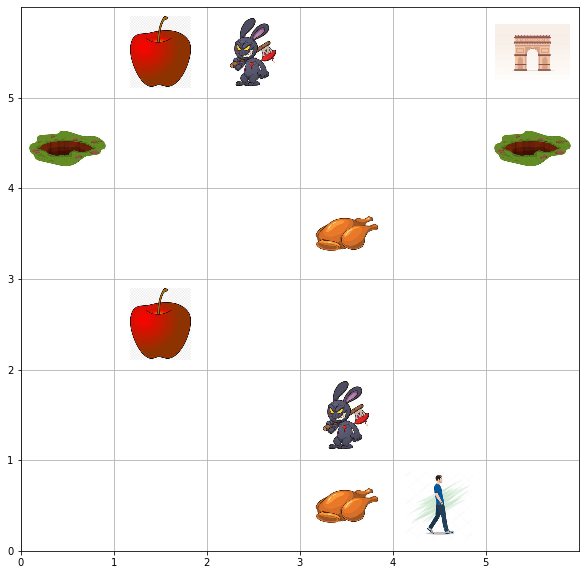

 90%|█████████ | 63/70 [00:16<00:02,  3.11it/s]

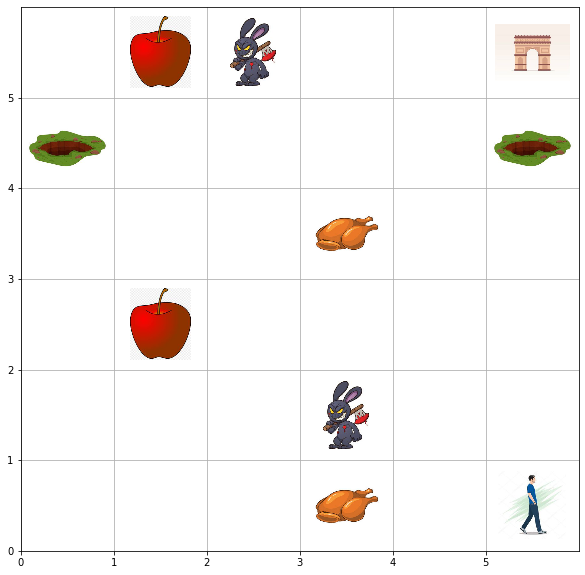

 91%|█████████▏| 64/70 [00:17<00:02,  2.97it/s]

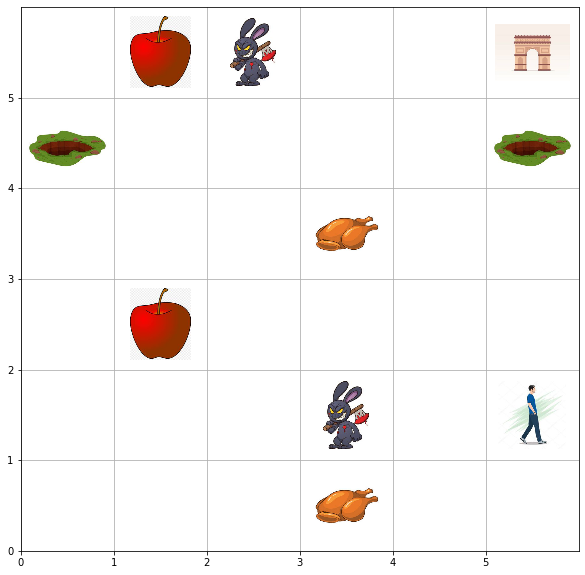

 93%|█████████▎| 65/70 [00:17<00:01,  3.04it/s]

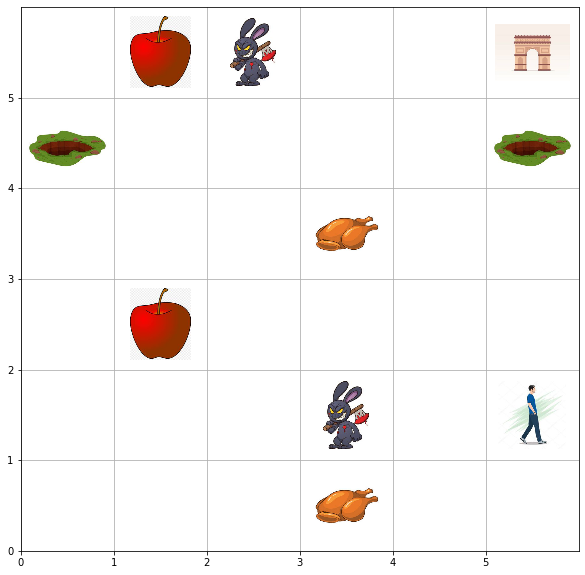

 94%|█████████▍| 66/70 [00:17<00:01,  3.10it/s]

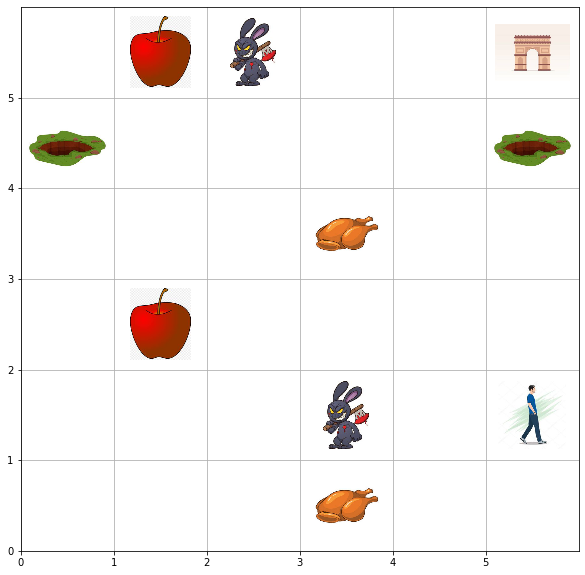

 96%|█████████▌| 67/70 [00:18<00:00,  3.10it/s]

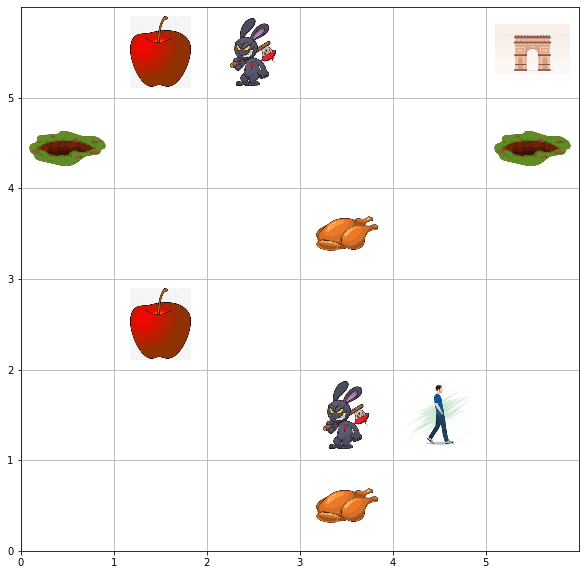

 97%|█████████▋| 68/70 [00:18<00:00,  3.11it/s]

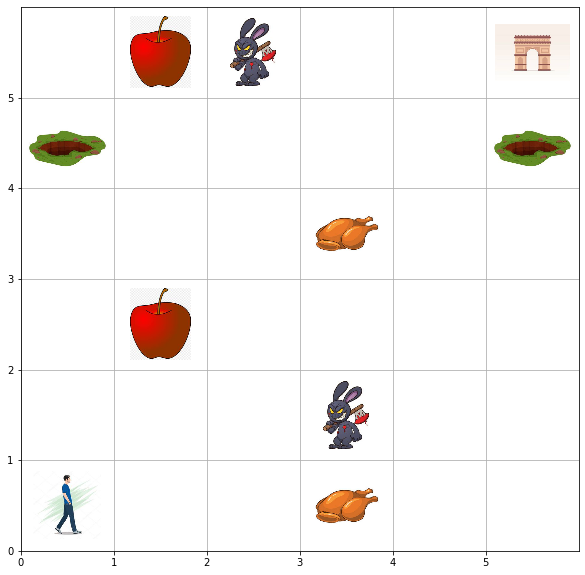

 99%|█████████▊| 69/70 [00:18<00:00,  3.13it/s]

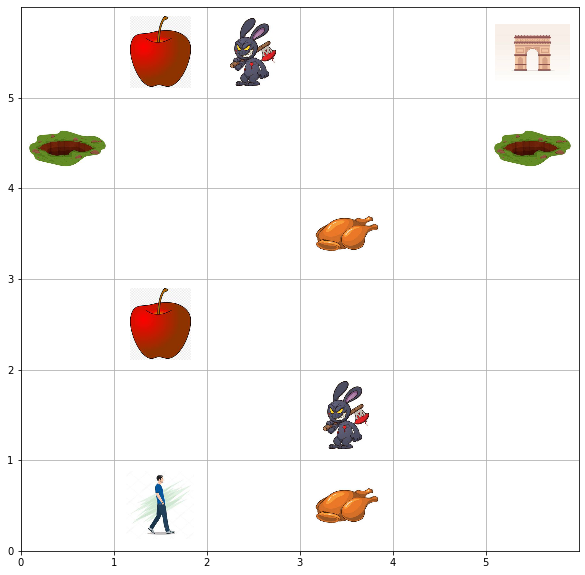

100%|██████████| 70/70 [00:19<00:00,  3.66it/s]


Training Averaged reward per episode -2964.8571
Saving output to img/result_img_1.png


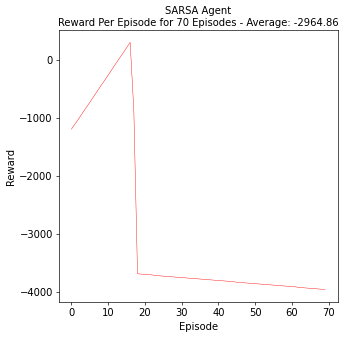

Done.


In [95]:
import gym
import numpy as np
from tqdm import trange # Processing Bar
import matplotlib.pyplot as plt
env=GridEnvironment()

class Lostman(object):
      def __init__(self):
            super(Lostman, self).__init__()
            print('Initialize environment...')
            self.env = self.initialize_env()
            self.n_states, self.n_actions = self.env.observation_space.n, self.env.action_space.n
            self.RESULT_IMG_PATH = 'img/result_img_{}.png'

      def initialize_env(self):
            env = env=GridEnvironment()
            return env

      def random_agent(self, n_episodes):
            t = trange(n_episodes)
            reward_array = np.zeros(n_episodes)
            for i in t: 
                  self.env.reset()
                  done = False
                  while not done:
                        action = np.random.randint(self.n_actions)
                        _, reward, done, _ = self.env.step(action)
                        if done: 
                              t.set_description('Episode {} Reward {}'.format(i + 1, reward))
                              t.refresh()
                              reward_array[i] = reward
                              break
            # self.env.render()
            avg_reward = round(np.mean(reward_array), 4)
            print('Averaged reward per episode {}'.format(avg_reward))
            title = 'Random Strategy\nReward Per Episode for {} Episodes - Average: {:.2f}'.format(n_episodes, avg_reward)
            self.gen_img(reward_array, title, 0)

      # initialize the agent’s Q-table to zeros
      def init_q(self, s, a): 
            return np.zeros((s, a))

      # epsilon-greedy exploration strategy
      def epsilon_greedy(self, Q, epsilon, s):
            if np.random.random() <= epsilon:
                  return np.random.randint(self.n_actions)
            else:
                  return np.argmax(Q[s, :])

      def sarsa_agent(self, alpha, gamma, epsilon, n_episodes): # SARSA Process
            # initialize Q table
            Q = self.init_q(self.n_states, self.n_actions)
            t = trange(n_episodes)
            reward_array = np.zeros(n_episodes)
            for i in t:
                  # initial state
                  s = self.env.reset()
                  s=s.astype(int)
                  a = self.epsilon_greedy(Q, epsilon, s)
                  a = np.clip(a, 0, 4)
                  done = False
                  while not done:
                        s_, reward, done, _ = self.env.step(a)
                        a_ = self.epsilon_greedy(Q, epsilon, s_)
                        a_ = np.clip(a_, 0, 4)
                        # update Q table
                        Q[s, a] += alpha * (reward + (gamma * Q[s_, a_]) - Q[s, a])
                        if done:
                              t.set_description('Episode {} Reward {}'.format(i + 1, reward))
                              t.refresh()
                              reward_array[i] = reward
                              break
                        s, a = s_, a_
            self.env.render()
            avg_reward = round(np.mean(reward_array), 4)
            return Q

      def eva(self, Q, n_episodes):
            t = trange(n_episodes)
            reward_array = np.zeros(n_episodes)
            for i in t:
                  s = self.env.render()
                  # initial action
                  a = np.argmax(Q[s])
                  done = False
                  while not done:
                        s_, reward, done, _ = self.env.step(a)
                        a_ = np.argmax(Q[s_])
                        a_ = np.clip(a_, 0, 4)
                        if done:
                              # t.set_description('Episode {} Reward {}'.format(i + 1, reward))
                              t.refresh()
                              reward_array[i] = reward
                              break
                        s, a = s_, a_
            avg_reward = round(np.mean(reward_array), 4)
            print('Training Averaged reward per episode {}'.format(avg_reward))
            title = 'SARSA Agent\nReward Per Episode for {} Episodes - Average: {:.2f}'.format(n_episodes, avg_reward)
            self.gen_img(reward_array, title, 1)

      def gen_img(self, reward_array, title, idx):
            # show reward per episode
            plt.subplots(figsize = (6, 6), dpi=60)
            plt.plot(reward_array, color='red', linewidth=0.5)
            plt.ylabel('Reward', fontsize=12)
            plt.xlabel('Episode', fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.title(title, fontsize=12)
            print('Saving output to ' + self.RESULT_IMG_PATH.format(idx))
            plt.show()
def main():

      fl = Lostman()
      print('\nSARSA agent:')
      Q = fl.sarsa_agent(0.1, 0.72, 0.5, 70) #sarsa_agent(self, alpha, gamma, epsilon, n_episodes)
      reward_array = fl.eva(Q, 70)
      print('Done.')

if __name__ == '__main__':
      main()